#### HW Overview

Please complete all core assignment tasks. For 50% bonus points please complete the optional stretech assignment tasks that will involve more theory and programming.

The goals of this HW include the following:
* master pipelines for regression prediction problems
  * Exploratory data analysis
  * Date preprocessing
    * Data standardization
    * Deal with missing data
    * Dealing with categorical input features via, say, OHE 
  * Linear regression modeling (regularized or not)
  * Various performance metrics
  
  
Please consult Canvas for the grading rubric (check Module 05 -> HW 05).

Broadly speaking you will be graded on the following (please consult Canvas for the final breakdown:

1. Download the data [5 points]
1. Set and perfrom Gridsearch over the hyperparameter possibilies [5 points]
1. Visualize the results of gridsearch and report best model combination [5 points]
1. Report perfromance on the held out test set and present Table of experimental results (for the different models) [5 points]
1. For optional tasks (10 points each):
    * we will have an additional task of code review [5 points] which will take the place of data downloading task.

# Preparation

Import required libraries

In [132]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style for plotting

In [133]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Fix random seed for reproducibility

In [134]:
np.random.seed(42)

# Boston House Prices

We have seen this dataset previously while working with KNN Regression. In this notebook, we're going to build a different regression model for predicting house prices in thousands of dollars given factors such as crime rate in neighborhood, number of schools, % lower status of the population, etc.

## Reading data

Boston dataset is extremely common in machine learning experiments thus it is embedded in sklearn.

In [135]:
boston = load_boston()

Detailed description of dataset and features

In [136]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Create pandas dataframe with objects in rows and features in columns

In [137]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [138]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Exploratory data analysis (EDA)

All features are numerical, but note that some features are categorical (e.g., CHAS) while others are continuous.

In [139]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Let's also take a look into correlation matrix of features

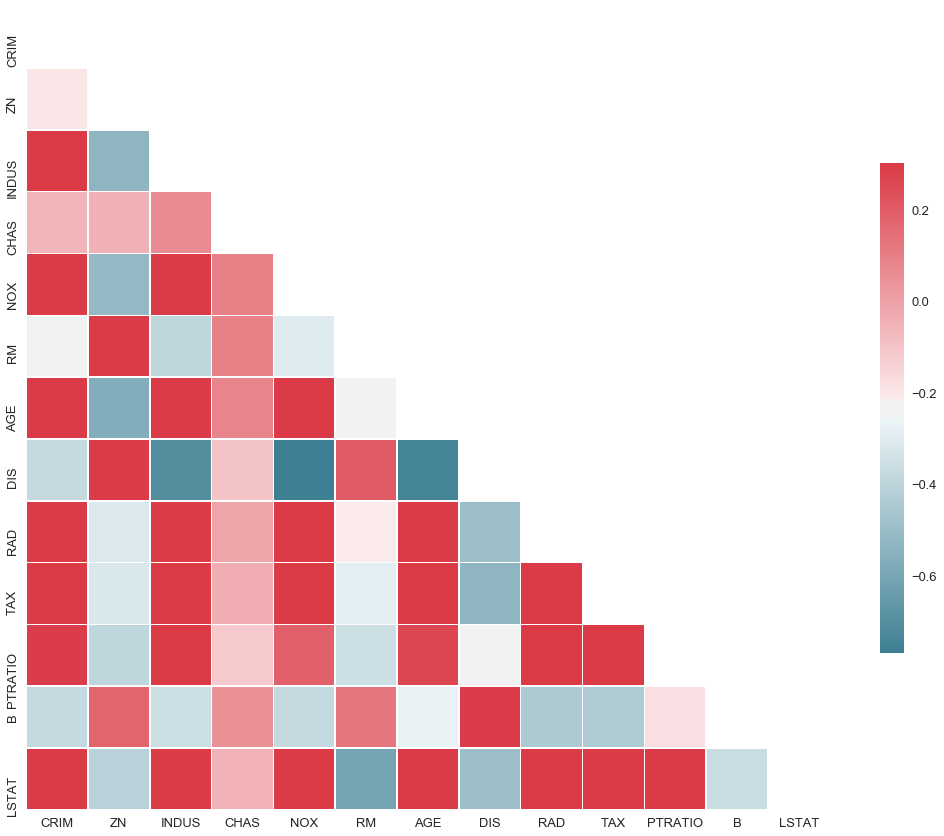

In [140]:
# compute the correlation matrix
corr = X.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

## Preprocessing

### Splitting the data (train/test)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

There are lots of feature. Let's visualize two of them across the train and test data. 

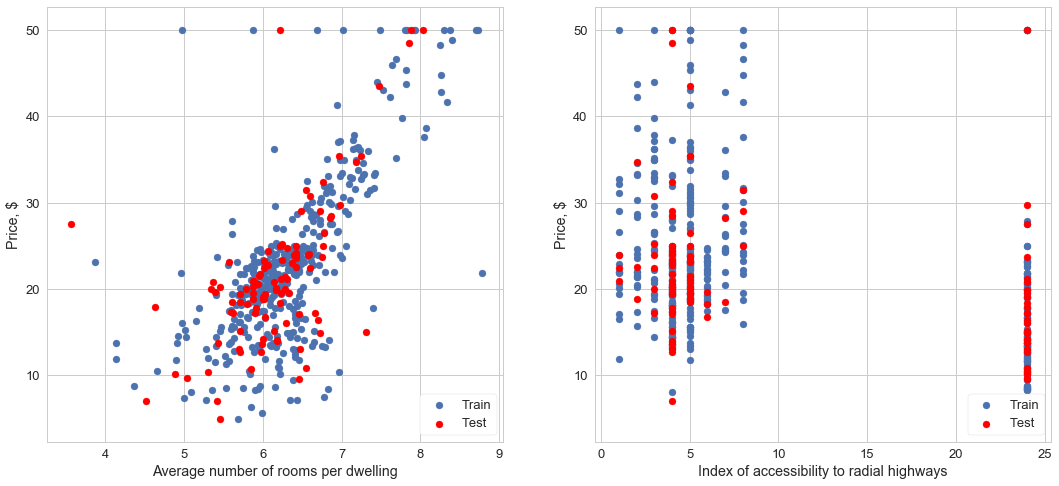

In [142]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.scatter(X_train.RM, y_train, label="Train")
plt.scatter(X_test.RM, y_test, c="r", label="Test")
plt.xlabel("Average number of rooms per dwelling")
plt.ylabel("Price, $")
plt.legend(loc="lower right", frameon=True)
plt.subplot(122)
plt.scatter(X_train.RAD, y_train, label="Train")
plt.scatter(X_test.RAD, y_test, c="r", label="Test")
plt.xlabel("Index of accessibility to radial highways")
plt.ylabel("Price, $")
plt.legend(loc="lower right");

### Scaling

Normalize data in the range $(0,1)$ to make our data insensitive to the scale of features.

In [143]:
scaler = MinMaxScaler()

Note that we're going to learn normalization constants only on training set. That's done because the assumption is that test set is unreachable during training.

In [144]:
X_train = scaler.fit_transform(X_train)

Transform test set with the same constants

In [145]:
X_test.info

<bound method DataFrame.info of          CRIM    ZN  INDUS  CHAS     NOX     RM    AGE      DIS   RAD    TAX  \
173   0.09178   0.0   4.05   0.0  0.5100  6.416   84.1   2.6463   5.0  296.0   
274   0.05644  40.0   6.41   1.0  0.4470  6.758   32.9   4.0776   4.0  254.0   
491   0.10574   0.0  27.74   0.0  0.6090  5.983   98.8   1.8681   4.0  711.0   
72    0.09164   0.0  10.81   0.0  0.4130  6.065    7.8   5.2873   4.0  305.0   
452   5.09017   0.0  18.10   0.0  0.7130  6.297   91.8   2.3682  24.0  666.0   
76    0.10153   0.0  12.83   0.0  0.4370  6.279   74.5   4.0522   5.0  398.0   
316   0.31827   0.0   9.90   0.0  0.5440  5.914   83.2   3.9986   4.0  304.0   
140   0.29090   0.0  21.89   0.0  0.6240  6.174   93.6   1.6119   4.0  437.0   
471   4.03841   0.0  18.10   0.0  0.5320  6.229   90.7   3.0993  24.0  666.0   
500   0.22438   0.0   9.69   0.0  0.5850  6.027   79.7   2.4982   6.0  391.0   
218   0.11069   0.0  13.89   1.0  0.5500  5.951   93.8   2.8893   5.0  276.0   
9     0.

In [146]:

X_test = scaler.transform(X_test)

In [147]:
type(X)

pandas.core.frame.DataFrame

In [148]:
#y.hist()
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


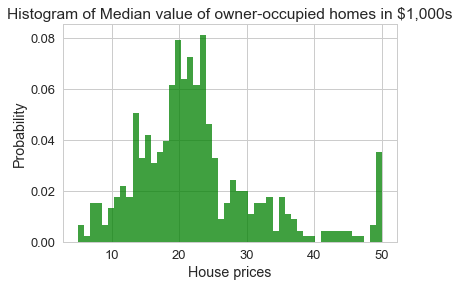

In [149]:

# the histogram of the data
n, bins, patches = plt.hist(y, 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('House prices')
plt.ylabel('Probability')
plt.title(r'Histogram of Median value of owner-occupied homes in $1,000s')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

### Plot distributions of each input variable

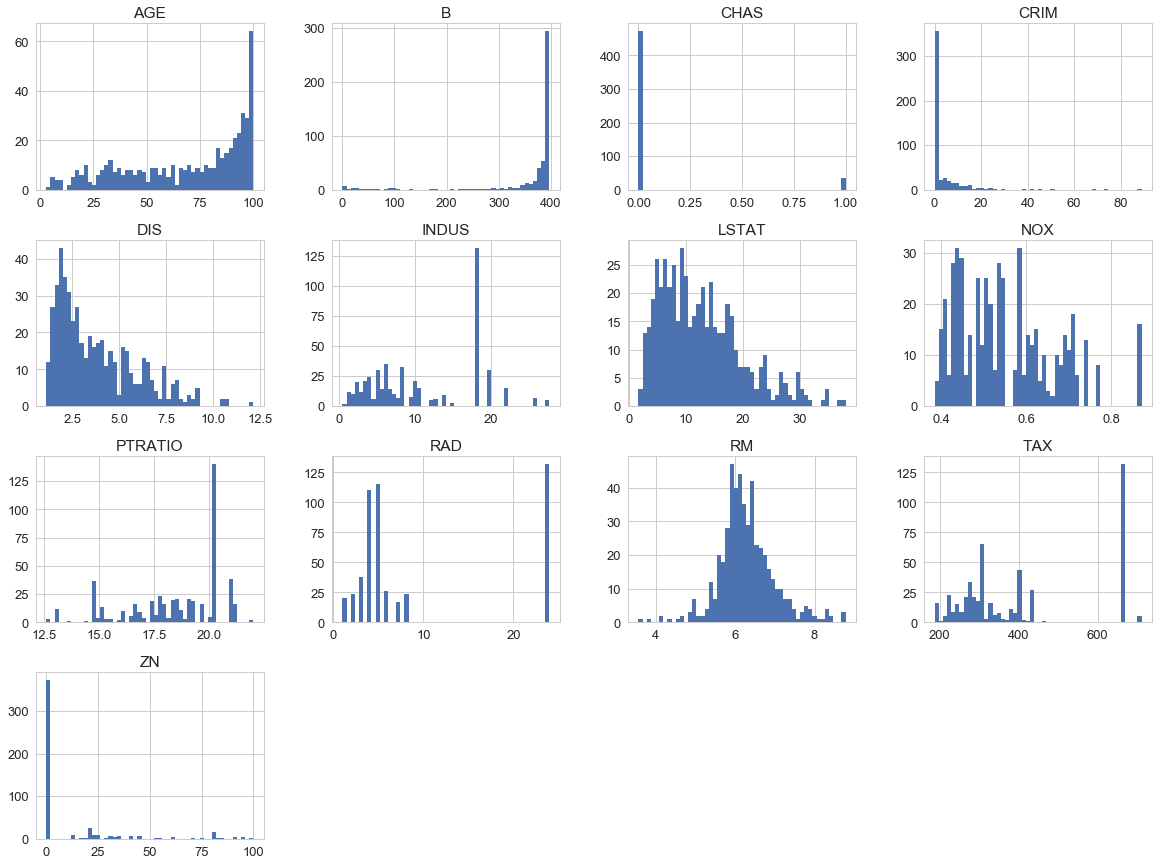

In [150]:
%matplotlib inline
import matplotlib.pyplot as plt
X.hist(bins=50, figsize=(20,15))
plt.show()

# Sklearn Linear Regression

## Fitting

Here we use very simple Linear Regression model. Scikit-learn uses the closed-form solition for Linear Regression problem thus it gives very good results.

In [151]:
model_sk = LinearRegression()

Fitting model on prepared data

In [152]:
model_sk.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Evaluation

Let's see what features are significant for the model. Largest coefficients will have greatest impact on the model.

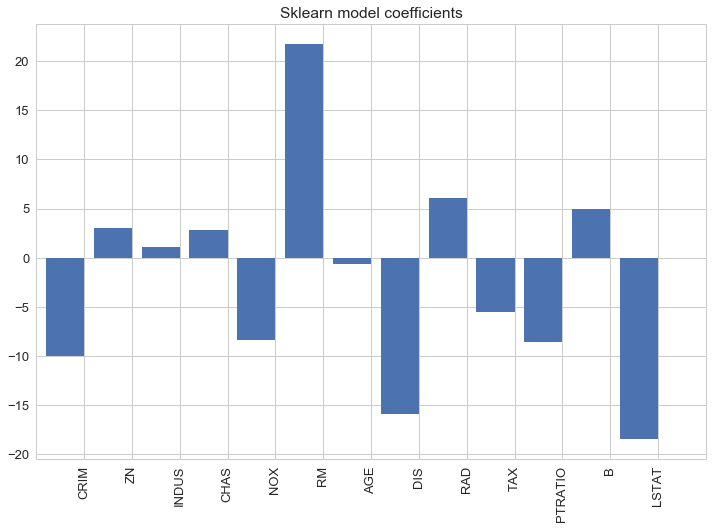

In [153]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_sk.coef_.shape[0]) - 0.4, model_sk.coef_)
plt.xticks(np.arange(model_sk.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Sklearn model coefficients");

Predicting both train and test sets to evaluate model

In [154]:
preds_test = model_sk.predict(X_test)
preds_train = model_sk.predict(X_train)

###  Mean absolute percentage error (MAPE)
There is no MAPE implementation in sklearn (because this metric is undefined when real value is zero). Below one can find my own implementation.

The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation. It usually expresses accuracy as a percentage, and is defined by the formula:

$${\displaystyle {\mbox{M}}={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|,} $$
where At is the actual value and Ft is the forecast value.

The difference between At and Ft is divided by the Actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.

Although the concept of MAPE sounds very simple and convincing, it has major drawbacks in practical application 

It cannot be used if there are zero values (which sometimes happens for example in demand data) because there would be a division by zero.
For forecasts which are too low the percentage error cannot exceed 100%, but for forecasts which are too high there is no upper limit to the percentage error.
When MAPE is used to compare the accuracy of prediction methods it is biased in that it will systematically select a method whose forecasts are too low. This little-known but serious issue can be overcome by using an accuracy measure based on the ratio of the predicted to actual value (called the Accuracy Ratio), this approach leads to superior statistical properties and leads to predictions which can be interpreted in terms of the geometric mean.

For more details on MAPE please see [here](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)

In [155]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Use of this metric is not recommended because can cause division by zero
    See other regression metrics on sklearn docs:
      http://scikit-learn.org/stable/modules/classes.html#regression-metrics
    Use like any other metric
    >>> y_true = [3, -0.5, 2, 7]; y_pred = [2.5, -0.3, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    Out[]: 24.791666666666668
    """

    return np.mean(np.abs((y_true.ravel() - y_pred.ravel()) / y_true.ravel())) * 100

Let's evaluate our model according to three different metrics:
* MAE (Mean Absolute Error)
* RMSE (Root Mean Squared Error)
* MAPE (Mean Absolute Percentage Error)

In [156]:
metrics = [mean_absolute_error, 
           lambda y_true, y_pred: mean_squared_error(y_true, y_pred) ** 0.5, 
           mean_absolute_percentage_error]
metrics_names = ["MAE", 
                 "RMSE", 
                 "MAPE"]

Also we want to check quality on both train and test sets

In [157]:
samples = [(X_train, y_train), 
           (X_test, y_test)]
models_names = ["Sklearn"]

Let's do it in loop

In [158]:
models_names = ["Sklearn"]

In [193]:
def evaluate(models, metrics, samples, metrics_names, models_names):
    results = np.zeros((len(samples) * len(models), len(metrics)))
    samples_names = []
    for m in models_names:
        samples_names.extend([m + " Train", m + " Test"])
    for m_num, model in enumerate(models):
        for row, sample in enumerate(samples):
            for col, metric in enumerate(metrics):
                results[row + m_num * 2, col] = metric(sample[1], model.predict(sample[0]))
    results = pd.DataFrame(results, columns=metrics_names, index=samples_names)
    return results

In [160]:
models = [model_sk]

Evaluated metrics:

In [194]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Full GD Train,3.570690,5.148422,17.504468
Homegrown Full GD Test,3.384323,5.290366,18.214940
Homegrown SGD Train,3.569371,5.157622,17.496304
Homegrown SGD Test,3.383569,5.306349,18.208680


It also interesting to take a look how the predicted points relate to real ones. All the points should lie on the black dotted line ($y=x$) assuming that our model is perfect

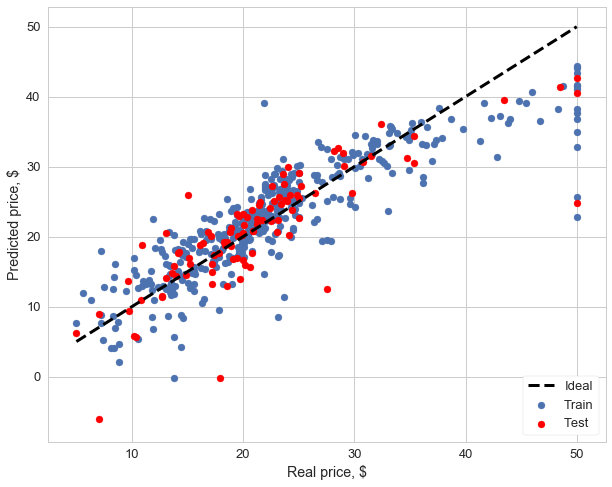

In [27]:
plt.figure(figsize=(10, 8))
plt.scatter(y_train, preds_train, label="Train")
plt.scatter(y_test, preds_test, c="r", label="Test")
plt.xlabel("Real price, $")
plt.ylabel("Predicted price, $")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3, label="Ideal")
plt.legend(loc="lower right");

## Cross-validation

The common method to evaluate the model is cross-validation. The idea behind it is to divide the whole set of objects into $k$ sections and then use one section as a test set and other $k-1$ as a train (repeat it with all the sections).

There is a special function for this in sklearn called $\text{KFold}$. It creates set of indices for cross-validation.

In [28]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

Next step is to do everything that we've done before in a loop:
* Split
* Scale
* Train
* Evaluate

And store the average value of the errors ($\text{res}$ variable)

In [29]:
cv_idx = list(cv.split(X_train, y_train))

In [30]:
res = None
for train_idx, test_idx in cv_idx:
    # split
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # scale
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    samples_cv = [(X_train, y_train), 
                  (X_test, y_test)]
    
    # fit
    model_sk_cv = LinearRegression().fit(samples_cv[0][0], samples_cv[0][1])
    
    # evaluate
    if res is None:
        res = evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
    else:
        res += evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
# take the average value across all folds
res /= cv.n_splits

Here is the result of CV

In [31]:
res

,MAE,RMSE,MAPE
Sklearn CV Train,3.291561,4.732208,15.403616
Sklearn CV Test,3.470811,5.078768,16.195264


# Core Task:  Boston Regression via pipelines 

Using the Boston dataset from above (train, and blind test split). 

Core Assignment: Cross-validation with k=10 and stdev
Repeat the above experiment but change the code so that you can compute the standard deviation of the various metrics of interest (i.e., report MAE and stdMAE, RMSE and stdRMSE etc.) via cross-validation with k=10. 

## Data Prepairations

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True
np.random.seed(42)
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Use of this metric is not recommended because can cause division by zero
    See other regression metrics on sklearn docs:
      http://scikit-learn.org/stable/modules/classes.html#regression-metrics
    Use like any other metric
    >>> y_true = [3, -0.5, 2, 7]; y_pred = [2.5, -0.3, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    Out[]: 24.791666666666668
    """

    return np.mean(np.abs((y_true.ravel() - y_pred.ravel()) / y_true.ravel())) * 100

def evaluate(models, metrics, samples, metrics_names, models_names):
    results = np.zeros((len(samples) * len(models), len(metrics)))
    samples_names = []
    for m in models_names:
        samples_names.extend([m + " Train", m + " Test"])
    for m_num, model in enumerate(models):
        for row, sample in enumerate(samples):
            for col, metric in enumerate(metrics):
                results[row + m_num * 2, col] = metric(sample[1], model.predict(sample[0]))
    results = pd.DataFrame(results, columns=metrics_names, index=samples_names)
    return results

## Cross-validation with k=10 

In [7]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_idx = list(cv.split(X_train, y_train))
res_cum_train = None
res_cum_test = None
res=None

for train_idx, test_idx in cv_idx:
    # split
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # scale
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    samples_cv = [(X_train, y_train), 
                  (X_test, y_test)]
    
    
    # fit
    model_sk_cv = LinearRegression().fit(samples_cv[0][0], samples_cv[0][1])
    
    metrics = [mean_absolute_error, 
           lambda y_true, y_pred: mean_squared_error(y_true, y_pred) ** 0.5, 
           mean_absolute_percentage_error]
    metrics_names = ["MAE", 
                 "RMSE", 
                 "MAPE"]
    #print(metrics_names)
    res1=evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
    res_train=pd.DataFrame(res1,index=["Sklearn CV Train"])
    res_test=pd.DataFrame(res1,index=["Sklearn CV Test"])
    
    # evaluate
    res_cum_train=pd.concat([res_cum_train,res_train])
    res_cum_test=pd.concat([res_cum_test,res_test])
    if res is None:
        res = res1
    else:
        res += res1
    


# take the average value across all folds
res /= cv.n_splits
columns=["stdMAE","stdRMSE","stdMAPE"]

df_train_std=pd.DataFrame(np.array(res_cum_train.std()).reshape((1,3)),columns=columns,index=["Sklearn CV Train"])
df_test_std=pd.DataFrame(np.array(res_cum_test.std()).reshape((1,3)),columns=columns,index=["Sklearn CV Test"])
print(cv.n_splits," CV errors for training data sets:\n",res_cum_train,"\n")
print(cv.n_splits," CV errors for testing data sets:\n",res_cum_test)
res_std=pd.concat([df_train_std,df_test_std])
res_all=pd.concat([res,res_std],axis=1)
res_all

10  CV errors for training data sets:
                        MAE      RMSE       MAPE
Sklearn CV Train  2.487453  3.191824  10.370346
Sklearn CV Train  2.438446  3.124375  10.229098
Sklearn CV Train  2.393635  3.093465   9.805079
Sklearn CV Train  2.332926  3.058177   9.876526
Sklearn CV Train  2.496987  3.194026  10.501199
Sklearn CV Train  2.344392  3.070075   9.640064
Sklearn CV Train  2.369013  3.052431   9.952487
Sklearn CV Train  2.338252  3.017842   9.911138
Sklearn CV Train  2.379354  3.085097   9.955962
Sklearn CV Train  2.482599  3.167471  10.362103 

10  CV errors for testing data sets:
                       MAE      RMSE       MAPE
Sklearn CV Test  2.051640  2.461202   9.346511
Sklearn CV Test  2.193677  3.157109   9.089330
Sklearn CV Test  2.893644  3.573081  14.696478
Sklearn CV Test  3.097658  3.680632  11.586783
Sklearn CV Test  1.713317  2.380363   6.719835
Sklearn CV Test  3.007262  3.764850  14.062707
Sklearn CV Test  2.978856  3.865915  10.992871
Sklearn CV Test  

,MAE,RMSE,MAPE,stdMAE,stdRMSE,stdMAPE
Sklearn CV Train,2.406306,3.105478,10.060400,0.064798,0.061501,0.284872
Sklearn CV Test,2.600758,3.328468,10.907568,0.534689,0.595318,2.371477


## Visualize the results

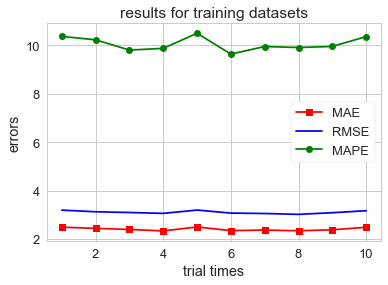

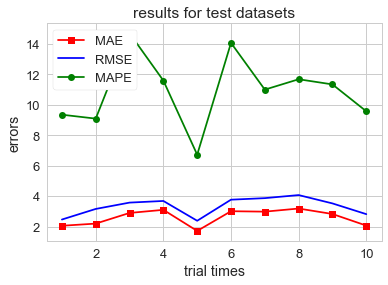

In [8]:
import matplotlib.pyplot as plt
import numpy as np
metrics_names = ["MAE", 
                 "RMSE", 
                 "MAPE"]
colors=["r","b","g"]
markers=["s","x","o"]
for l,c,m in zip(metrics_names,colors,markers):
    plt.plot(np.arange(1,11,1),res_cum_train.loc[:,l],c=c,label=l,marker=m)
plt.xlabel("trial times")
plt.ylabel("errors")
plt.title("results for training datasets")
plt.legend(loc="best")
plt.show()

for l,c,m in zip(metrics_names,colors,markers):
    plt.plot(np.arange(1,11,1),res_cum_test.loc[:,l],c=c,label=l,marker=m)
plt.xlabel("trial times")
plt.ylabel("errors")
plt.title("results for test datasets")
plt.legend(loc="best")
plt.show()

# Core Task: Predicting Bike Sharing Demand (Kaggle competition)

The question provides a lot of background and sample code that you should review, run and extend to get familar with this problem and data set. Then you should tackle the tasks posed at the end of this question.

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world [as of 2014].

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.



Overview on the project:

* The objective is to predict the number of bikes that will be rented using the provided  data.
* You will use various python packages like numpy, pandas, seaborn and standardScaler are used to explore and do feature engineering on data.
* Finally you will build linear regression models and evalaute them using various metrics such as mean_squared_error
* Do a Kaggle submission and get a score for your submission. Please screenshot that and report it.
  * You won’t show up on the leaderboard, but you can still submit and get a score for your submission.



In [53]:
%cd shared/Dropbox/Projects/Courses/DataScienceAtScale/Assignments/Unit-05_Regression_BostonHousePrices/

/root/shared/Dropbox/Projects/Courses/DataScienceAtScale/Assignments/Unit-05_Regression_BostonHousePrices


## Load Data

In [100]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
train=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/train.csv')
test=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/test.csv')

## EDA: Understanding the bike demand data det and doing EDA 

Understanding the Data Set
The dataset shows hourly rental data for two years (2011 and 2012). The training data set is for the first 19 days of each month. The test dataset is from 20th day to month’s end. We are required to predict the total count of bikes rented during each hour covered by the test set.

In the training data set, they have separately given bike demand by registered, casual users and sum of both is given as count.

Training data set has 12 variables (see below) and Test has 9 (excluding registered, casual and count).

Independent Variables

```
datetime:   date and hour in "mm/dd/yyyy hh:mm" format
season:     Four categories-> 1 = spring, 2 = summer, 3 = fall, 4 = winter
holiday:    whether the day is a holiday or not (1/0)
workingday: whether the day is neither a weekend nor holiday (1/0)
weather:    Four Categories of weather
            1-> Clear, Few clouds, Partly cloudy, Partly cloudy
            2-> Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3-> Light Snow and Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4-> Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp:       hourly temperature in Celsius
atemp:      "feels like" temperature in Celsius
humidity:   relative humidity
windspeed:  wind speed
Dependent Variables

registered: number of registered user
casual:     number of non-registered user
count:      number of total rentals (registered + casual)
```
Notice the Training dataset has 3 target features:

```
registered: number of registered user
casual:     number of non-registered user
count:      number of total rentals (registered + casual)
```


** Here we will focus on predicting `count` feature initially.**

In [62]:
print("TRAIN", train.shape)
print("TEST", test.shape)

TRAIN (10886, 12)
TEST (6493, 9)


In [59]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [63]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Check if there is any missing value.

In [2]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [66]:
train.describe()  #summary statistics for each variable

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


### Plot the feature distributions (including the targets: count, casual, registered)

In [68]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


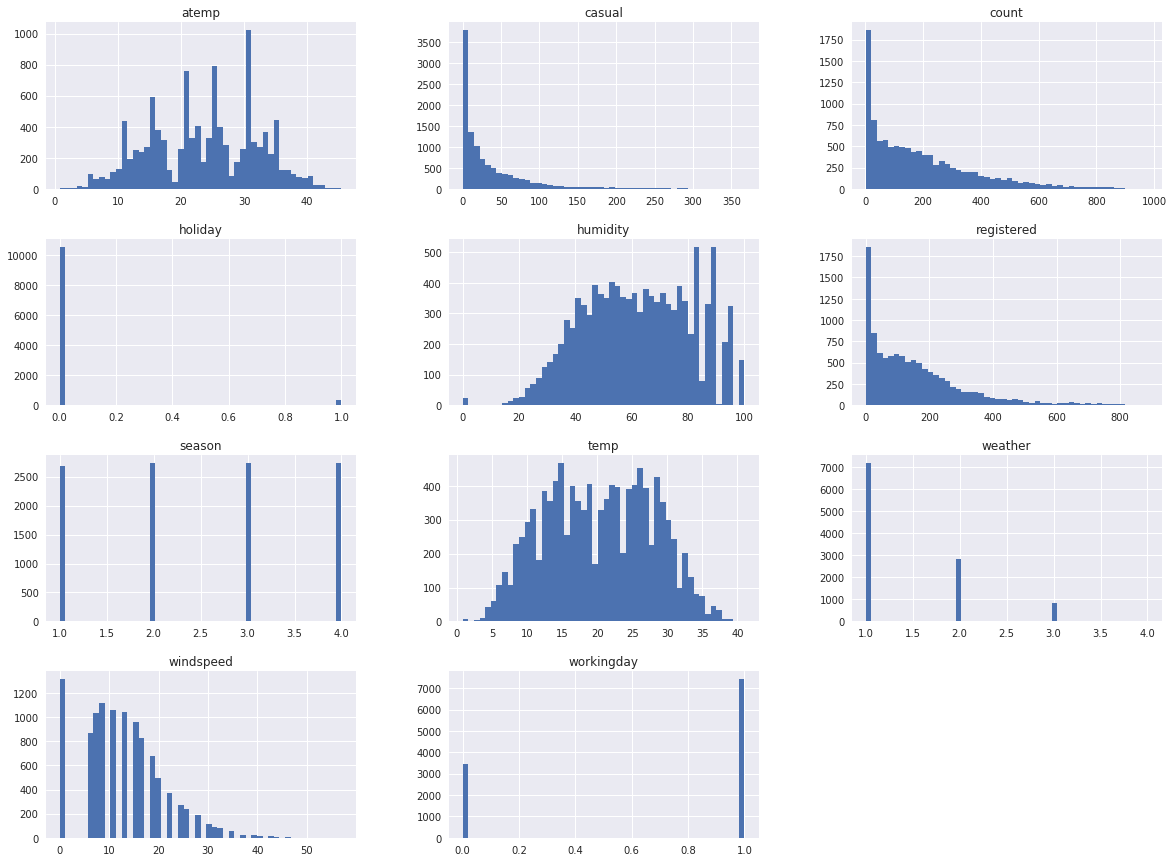

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,15))
plt.show()

### Pandas and Dataframes

In computer programming, `pandas` is a software library written for the Python programming language for data manipulation and analysis. Data is stored in tabular format.  In particular, it offers data structures and operations for manipulating numerical tables and time series. 

The Panda Library features include:

* DataFrame object for data manipulation with integrated indexing.
* Tools for reading and writing data between in-memory data structures and different file formats.
* Data alignment and integrated handling of missing data.
* Reshaping and pivoting of data sets.
* Label-based slicing, fancy indexing, and subsetting of large data sets.
* Data structure column insertion and deletion.
* **Group by engine allowing split-apply-combine operations on data sets.**
* Data set merging and joining.
* Hierarchical axis indexing to work with high-dimensional data in a lower-dimensional data structure.
* Time series-functionality: 
  * Date range generation[3] and frequency conversion, 
  * moving window statistics, 
  * moving window linear regressions, 
  * date shifting and lagging.


For more info on Pandas dataframes see the following:

* [Pandas intro](https://pandas.pydata.org/pandas-docs/stable/dsintro.html)
* [Wiki entry for Pandas](https://en.wikipedia.org/wiki/Pandas_(software))


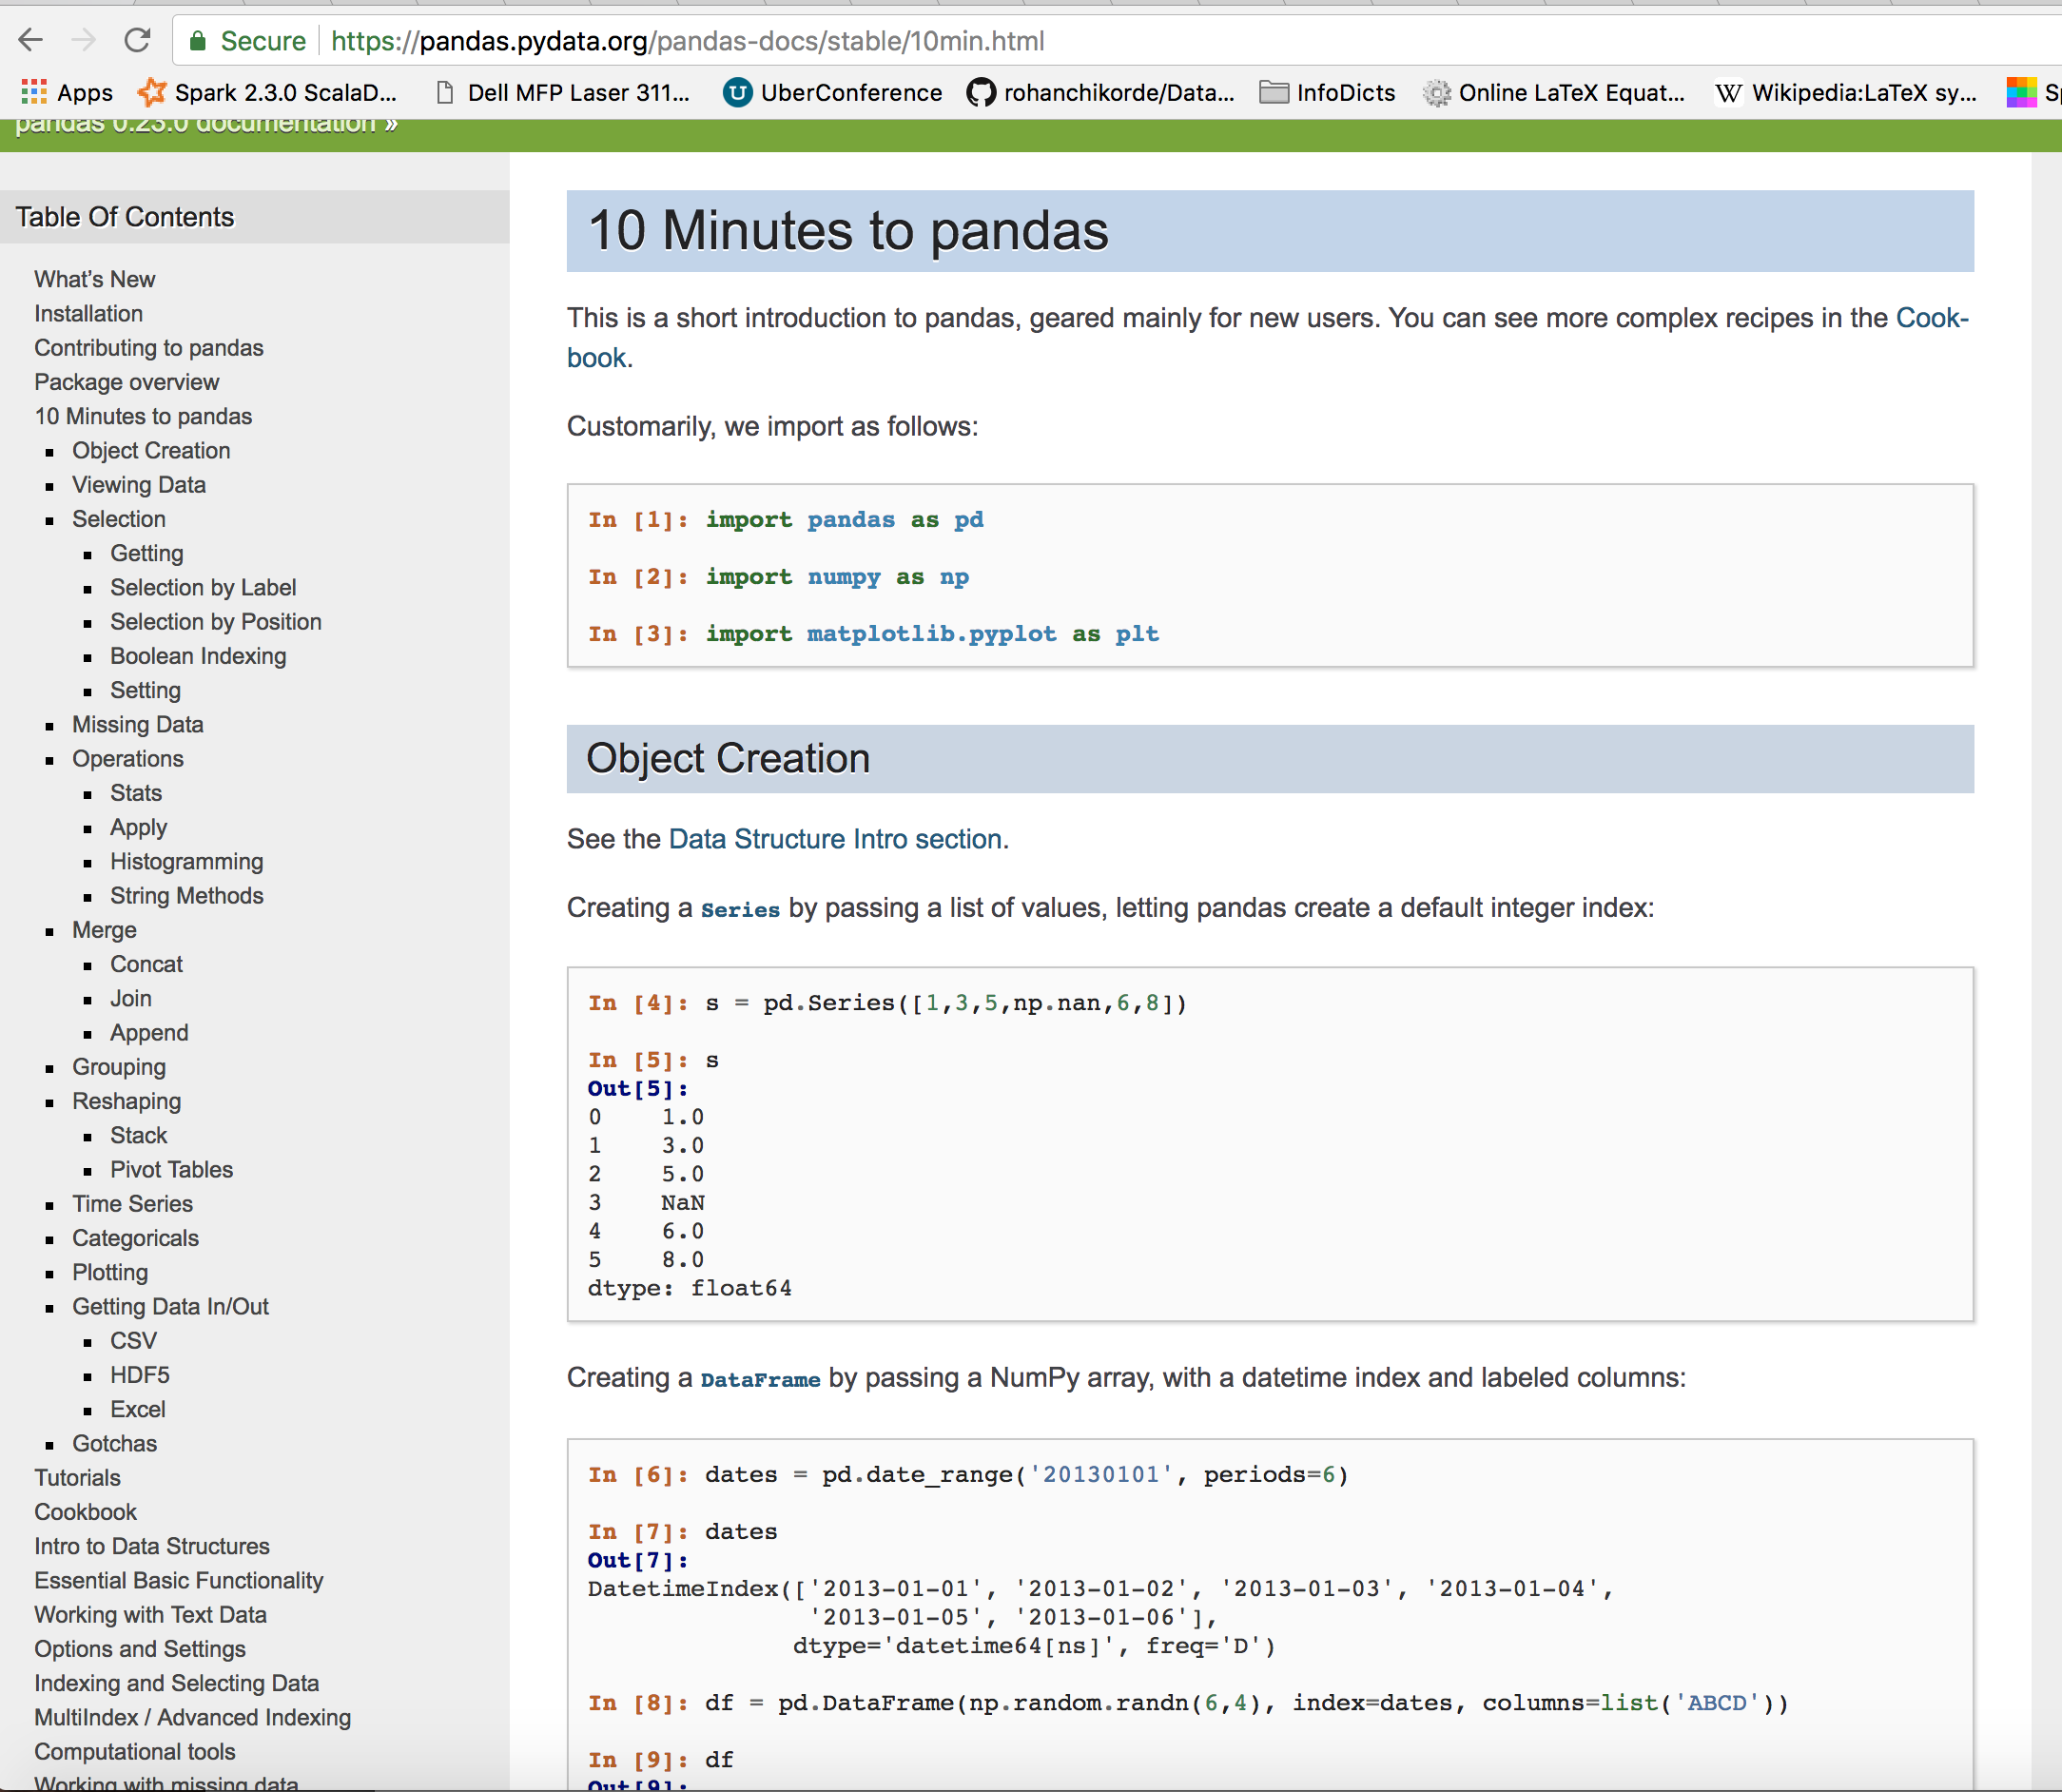



#### GROUP BY analysis: Sample use of a GROUP BY analysis: E.g., Season, or Holiday


E.g., 

* groupby(['holiday']) to see if the target value varies between holiday and not holiday.
* groupby(['season'] to see if the target value varies between holiday and not holiday.


In [31]:
train[['count', 'holiday']].groupby(['holiday'], as_index = True).mean().sort_values(by = 'count')

,count
holiday,
1,185.877814
0,191.741655


In [30]:
train[['count', 'season']].groupby(['season'], as_index = True).mean().sort_values(by = 'count')

,count
season,
1,116.343261
4,198.988296
2,215.251372
3,234.417124


#### Visualize a categorical features like Season, weather 


```
weather:    Four Categories of weather
            1-> Clear, Few clouds, Partly cloudy, Partly cloudy
            2-> Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3-> Light Snow and Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4-> Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

```

In [3]:
train.season.unique()

array([1, 2, 3, 4], dtype=int64)

In [4]:
train.weather.value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [5]:
train.holiday.value_counts()

0    10575
1      311
Name: holiday, dtype: int64

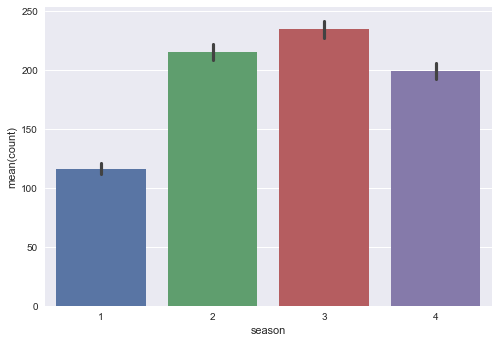

In [6]:
sns.barplot(x='season', y='count', data=train)

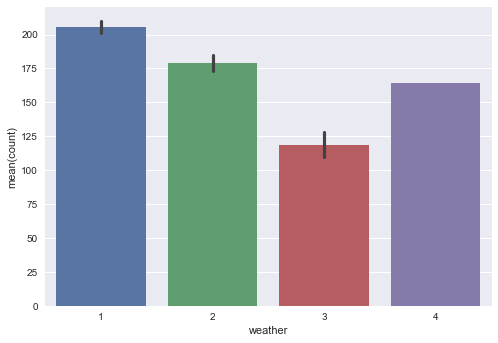

In [7]:
sns.barplot(x='weather', y='count', data=train)

In [ ]:
X, y = train.iloc[:, 1:-3], train['count']


## One hot encoding (OHE)
Features like season, holiday, weather and working day are in  numerical form here. Having said that the numerical values associated with feature like weather dont have any particular numeric ordering. As such, it is much better to one hot encode these features. Here we can do this manually (via code) for training and testing datasets. Later in this course we automate this process in a more principled manner (we have to deal with corner cases.  

* Further, found in the year column, there are just 2 different years 2011,2012 so using map(), we convert  2011 and 2012 to 0 and 1 respectively. 



In [95]:
# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
train['weather1'] = np.where(train['weather']==1, 1, 0)  #ifelse assignment
train['weather2'] = np.where(train['weather']==2, 1, 0)
train['weather3'] = np.where(train['weather']==3, 1, 0)
train['weather4'] = np.where(train['weather']==4, 1, 0)

# dont forget to drop the original feature
train.drop(['weather'], axis=1)

,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,weather1,weather2,weather3,weather4
0,2011-01-01 00:00:00,1,0,0,9.84,14.395,81,0.0000,3,13,16,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,9.02,13.635,80,0.0000,8,32,40,1,0,0,0
2,2011-01-01 02:00:00,1,0,0,9.02,13.635,80,0.0000,5,27,32,1,0,0,0
3,2011-01-01 03:00:00,1,0,0,9.84,14.395,75,0.0000,3,10,13,1,0,0,0
4,2011-01-01 04:00:00,1,0,0,9.84,14.395,75,0.0000,0,1,1,1,0,0,0
5,2011-01-01 05:00:00,1,0,0,9.84,12.880,75,6.0032,0,1,1,0,1,0,0
6,2011-01-01 06:00:00,1,0,0,9.02,13.635,80,0.0000,2,0,2,1,0,0,0
7,2011-01-01 07:00:00,1,0,0,8.20,12.880,86,0.0000,1,2,3,1,0,0,0
8,2011-01-01 08:00:00,1,0,0,9.84,14.395,75,0.0000,1,7,8,1,0,0,0
9,2011-01-01 09:00:00,1,0,0,13.12,17.425,76,0.0000,8,6,14,1,0,0,0


In [91]:
train.iloc[[7000]] ## Weather has a value of 2
#train.as_matrix()[322:330,]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weather1,weather2,weather3,weather4
7000,2012-04-10 00:00:00,2,0,1,2,18.04,21.97,47,19.0012,3,23,26,0,1,0,0


### Dont forget to OHE the test data


Dont forget to OHE the test data!!
..........

### Are there other features that should be OHE?

Hint: Season? Others?

## Create new  features (based on timestamp)
* Well, we have a datetime feature (more like an object) in this dataset.  Let's break it into hour, day, month, year and make them a separate column.


In [8]:
train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): based 

## Separate input features and target feature for TRAIN ONLY.

Why separate input features and target feature for TRAIN only?

Answer: The test set is for creating a Kaggle submission.


In [96]:
X, y = train.iloc[:, 1:], train['count']
X = train.drop(['datetime','registered', 'casual', 'count'], axis=1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weather1,weather2,weather3,weather4
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0,0,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,0,0,0
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,0,0,0


In [99]:
X.iloc[0:2,:]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weather1
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1


## Analysis of target variables

It was seen from the training data sum of registered column and casual column yields count.
It was unnecessary to keep these two columns as our features, Machine learning learners can be more fruitful if dataset is free of useless columns.

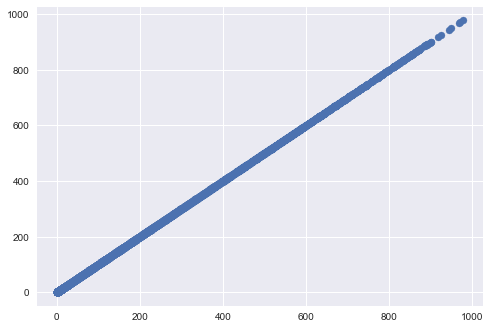

In [33]:
plt.scatter(x = train['casual'] + train['registered'], y = train['count'])
plt.show()

In [10]:
X = X.drop(['registered', 'casual', 'count'], axis=1)

## Applying machine learning models (i.e., linear regression, DTs)

### Split the training data into train and a blind test set 
Split the training data into train and a blind test set using scikit's train_test_split package. Rememeber that the test set that was provided is for Kaggle submission only and as such has not target values.


In [101]:
from sklearn.cross_validation import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Features on larger scales can unduly influence the model.
We want features on a similar scale.
Scikit's preprocessing provides us with StandardScaler package to scale our data.

In [129]:
from sklearn.preprocessing import StandardScaler
scl= StandardScaler()
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_std, y_train) #SKLearn's linear regression

y_train_pred = lin_reg.predict(X_train_std)
y_test_pred = lin_reg.predict(X_test_std)

In [130]:
from sklearn.metrics import mean_squared_error, r2_score
#Root_Mean_Square_Log_Error(RMSE) is accuracy criteria for this problem
print('RMSLE train: %.3f' % np.sqrt(mean_squared_error(y_train , y_train_pred))) #RMSE on raw count value

# errors on log transformed count, i.e., np.log(y_train + 1)
print('RMSLE train: %.3f' % np.sqrt(mean_squared_error(np.log(y_train + 1), np.log(y_train_pred + 1))))
print('RMSLE test: %.3f' % np.sqrt(mean_squared_error(np.log(y_test + 1), np.log(y_test_pred + 1))))
print('R2 train: %.3f' % r2_score(y_train, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test, y_test_pred))

RMSLE train: 0.000
RMSLE test: 0.000
R2 train: 1.000
R2 test: 1.000


### Keep a log book to track your experiments

In [131]:
expLog = pd.DataFrame(columns=["Model description", "RMSLE train", 'RMSLE test','R2 test'])

# add the result of this experiment ot the log book
expLog.loc[len(expLog)] = ["SKLearn Linear Regression vanilla",  
                np.round(np.sqrt(mean_squared_error(np.log(y_train + 1), np.log(y_train_pred + 1))), 3),
                np.round(np.sqrt(mean_squared_error(np.log(y_test + 1), np.log(y_test_pred + 1))),3),
                np.round(r2_score(y_test, y_test_pred), 3)
                            ]

In [132]:
expLog
expLog.loc[len(expLog)] = ["SKLearn Linear Regression vanilla",  
                np.round(np.sqrt(mean_squared_error(np.log(y_train + 1), np.log(y_train_pred + 1))), 3),
                np.round(np.sqrt(mean_squared_error(np.log(y_test + 1), np.log(y_test_pred + 1))),3),
                np.round(r2_score(y_test, y_test_pred), 3)
                            ]
expLog

,Model description,RMSLE train,RMSLE test,R2 test
0,SKLearn Linear Regression vanilla,0.0,0.0,1.0
1,SKLearn Linear Regression vanilla,0.0,0.0,1.0


### Learn a Decision Tree  Regressor
Let's learn a DecisionTreeRegressor model for comparison purposes.

In [133]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor()
clf.fit(X_train_std, y_train)
y_train_pred2 = clf.predict(X_train_std)
y_test_predd = clf.predict(X_test_std)
#Root_Mean_Square_Log_Error(RMSE) is accuracy criteria for this problem
print('RMSLE train: %.3f' % np.sqrt(mean_squared_error(np.log(y_train + 1), np.log(y_train_pred2 + 1))))
print('RMSLE test: %.3f' % np.sqrt(mean_squared_error(np.log(y_test + 1), np.log(y_test_predd + 1))))
print('R2 train: %.3f' % r2_score(y_train, y_train_pred2))
print('R2 test: %.3f' % r2_score(y_test, y_test_predd))

# add the result of this experiment ot the log book
expLog.loc[len(expLog)] = ["SKLearn DecisionTree vanilla",  
                np.round(np.sqrt(mean_squared_error(np.log(y_train + 1), np.log(y_train_pred + 1))), 3),
                np.round(np.sqrt(mean_squared_error(np.log(y_test + 1), np.log(y_test_pred + 1))),3),
                np.round(r2_score(y_test, y_test_pred), 3)
                            ]

RMSLE train: 0.000
RMSLE test: 0.001
R2 train: 1.000
R2 test: 1.000



### Learn a Decision Tree ensmble, .i.e., use RandomForestRegressor
Learn Decision Tree ensmble, RandomForestRegressor, model.

In [134]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 400, criterion='mse',random_state=1, n_jobs=-1)
forest.fit(X_train_std, y_train)
y_train_pred = forest.predict(X_train_std)
y_test_pred = forest.predict(X_test_std)

In [135]:
from sklearn.metrics import mean_squared_error, r2_score
#Root_Mean_Square_Log_Error(RMSE) is accuracy criteria for this problem
print('RMSLE train: %.3f' % np.sqrt(mean_squared_error(np.log(y_train + 1), np.log(y_train_pred + 1))))
print('RMSLE test: %.3f' % np.sqrt(mean_squared_error(np.log(y_test + 1), np.log(y_test_pred + 1))))
print('R2 train: %.3f' % r2_score(y_train, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test, y_test_pred))

# add the result of this experiment ot the log book
expLog.loc[len(expLog)] = ["SKLearn RandomForestRegressor vanilla",  
                np.round(np.sqrt(mean_squared_error(np.log(y_train + 1), np.log(y_train_pred + 1))), 3),
                np.round(np.sqrt(mean_squared_error(np.log(y_test + 1), np.log(y_test_pred + 1))),3),
                np.round(r2_score(y_test, y_test_pred), 3)
                            ]

RMSLE train: 0.000
RMSLE test: 0.000
R2 train: 1.000
R2 test: 1.000


In [136]:
expLog

,Model description,RMSLE train,RMSLE test,R2 test
0,SKLearn Linear Regression vanilla,0.0,0.0,1.0
1,SKLearn Linear Regression vanilla,0.0,0.0,1.0
2,SKLearn DecisionTree vanilla,0.0,0.0,1.0
3,SKLearn RandomForestRegressor vanilla,0.0,0.0,1.0


## Generate a submission file on the Kaggle test data.

In [16]:
test=pd.read_csv('test.csv')
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Dont forget to Generate features 

* from datatime object  (hour,day,month,year)
* OHE


In [17]:
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})

In [18]:
X_test=test.iloc[:,1:]

Similarly, use same standarad scaler for test data

In [19]:
X_test = scl.transform(X_test)

In [20]:
y_test=forest.predict(X_test)

In [21]:
df_submit = test

In [22]:
df_submit['count'] = np.round(y_test)

In [23]:
df_submit = df_submit.drop(['season', 'holiday', 'workingday','weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month', 'year'], axis=1)

In [24]:
df_submit.head()

,datetime,count
0,2011-01-20 00:00:00,12.0
1,2011-01-20 01:00:00,6.0
2,2011-01-20 02:00:00,4.0
3,2011-01-20 03:00:00,4.0
4,2011-01-20 04:00:00,3.0


In [25]:
df_submit.to_csv('bike2.csv', index=False)

### Now upload this submission file to Kaggle

Good luck!

## Core TASK: Report your results

This question (this entire section) so far has  provided a lot of background and sample code that you should review, run and extend to get familar with this problem and data set. Next up you should tackle the tasks posed here.  Please feel free to adapt the above code to accomplish the following:

Overall, we want you to build a linear regression model using pipelines that builds on what was discussed earlier in this section and do a Kaggle submission for this Bike Demand prediction problem. In particular, we want you to address the following:

* Derive other features 
  * OHE features such as  season, 
 
* Please do feature selection using `SelectKBest` 
  * See a full section on Feature Selection in Lab04 Notebook for details on how to do this. 
* Please put all modeling steps (including Feature Selection) in a Pipeline **(NOTE please keep the OHE step separate preprocessing step for this homework)**
* Present your experimental results in tabular form
  * Describe the linear regression model, number of input features used, MAE, RMSE and MAPE, feature familires used (e.g., Baseline features, Season OHE, etc.).
* Please do a Kaggle submission with your best linear regression model
* Screenshot your kaggle submission results
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). 

In [137]:
expLog

,Model description,RMSLE train,RMSLE test,R2 test
0,SKLearn Linear Regression vanilla,0.0,0.0,1.0
1,SKLearn Linear Regression vanilla,0.0,0.0,1.0
2,SKLearn DecisionTree vanilla,0.0,0.0,1.0
3,SKLearn RandomForestRegressor vanilla,0.0,0.0,1.0


## Data Preprocessing

### Data Loading

In [1]:
#load data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
train=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\train.csv')
#test=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\test.csv')

In [2]:
#Transform datetime into year,month,day,hour
train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): based 

### One Hot Encoder

In [3]:
#Define onehot encoder function
def onehotencoderhome(traindata,feature):
    # Create a new column called df.weather1 where the value is 1
    # if df.weather is 1 and 0 if not
    for f in np.unique(traindata[feature]):
        newfeature=feature+str(f)
        traindata[newfeature] = np.where(traindata[feature]==f, 1, 0)

    #drop the original feature    
    return traindata.drop(feature, axis=1)
  

In [4]:
#Onehot Encoder for weather,season, year
train=onehotencoderhome(train,"weather")
train=onehotencoderhome(train,"season")
train=onehotencoderhome(train,"year")
train.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,...,weather1,weather2,weather3,weather4,season1,season2,season3,season4,year0,year1
0,2011-01-01 00:00:00,0,0,9.84,14.395,81,0.0,3,13,16,...,1,0,0,0,1,0,0,0,1,0
1,2011-01-01 01:00:00,0,0,9.02,13.635,80,0.0,8,32,40,...,1,0,0,0,1,0,0,0,1,0
2,2011-01-01 02:00:00,0,0,9.02,13.635,80,0.0,5,27,32,...,1,0,0,0,1,0,0,0,1,0
3,2011-01-01 03:00:00,0,0,9.84,14.395,75,0.0,3,10,13,...,1,0,0,0,1,0,0,0,1,0
4,2011-01-01 04:00:00,0,0,9.84,14.395,75,0.0,0,1,1,...,1,0,0,0,1,0,0,0,1,0


### Train datasets and test datasets split

In [5]:
#X=features,y=target
y =train['count']
X = train.drop(['datetime','registered', 'casual', 'count'], axis=1)
#double check the data
X.iloc[0:2,:]

,holiday,workingday,temp,atemp,humidity,windspeed,hour,day,month,weather1,weather2,weather3,weather4,season1,season2,season3,season4,year0,year1
0,0,0,9.84,14.395,81,0.0,0,5,1,1,0,0,0,1,0,0,0,1,0
1,0,0,9.02,13.635,80,0.0,1,5,1,1,0,0,0,1,0,0,0,1,0


In [6]:
#split training dataset into training and test parts
from sklearn.cross_validation import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
print("training datasets:",X_train.shape)
print("Validate datasets:",X_test.shape)

training datasets: (7620, 19)
Validate datasets: (3266, 19)


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Feature Importance from SelectKBest

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

# SCORE  linear regression input variables using correlation producing F scores and corresponding p-values
# K is used select top k rated input features
def select_kbest_reg(data_frame, target, k=5):
    """
    Selecting K-Best features regression
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_regression, k=k)
    _ = feat_selector.fit(data_frame, target)
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.columns
    
    return feat_scores


In [8]:
per_feat=select_kbest_reg(X_train,y_train,k=7)
per_feat_sorted=per_feat.sort_values(["F Score","P Value"],ascending=[False,False])
top_k_feature_indices=per_feat_sorted["Attribute"].values.flatten()
feature_importances = per_feat[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances_sorted = per_feat_sorted[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances

,F Score,Attribute
0,0.033480,holiday
1,1.910518,workingday
2,1392.705790,temp
3,1345.313872,atemp
4,835.773721,humidity
5,76.400544,windspeed
6,1469.911208,hour
7,1.866755,day
8,230.585036,month
9,85.064471,weather1


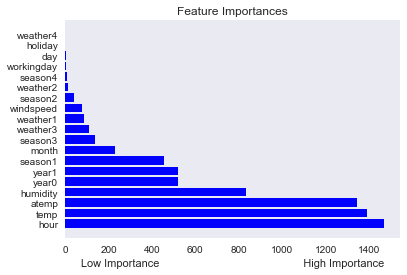

In [9]:
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure() 
plt.title("Feature importances")
sortedNames = np.array(feature_importances_sorted)[:, 1]
sortedImportances = np.array(feature_importances_sorted)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Low Importance                                                High Importance')
plt.grid()
plt.show()

## Pipeline

In [7]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

In [8]:
def rmsle(y,y_):
    log1=np.nan_to_num(np.array([np.log(v+1) for v in y]))
    log2=np.nan_to_num(np.array([np.log(v+1) for v in y_]))
    calc=(log1-log2)**2
    return np.sqrt(np.mean(calc))

In [12]:
#keep a log book to track experiments
expLog = pd.DataFrame(columns=["Model description", "K","RMSLE train", 'RMSLE test','R2 train','R2 test'])

### Linear Regression Model

In [13]:
#using selectKBest, and keep tracking how k impact the model performance
model_name="SKLearn Linear Regression"
for i in range(1,X_train.shape[1]+1):
    pipe_lr = Pipeline([
            ("std_scaler", StandardScaler()),
            ('feature_selection', SelectKBest(f_regression, k=i)),
            ('lineReg', LinearRegression())
        ])
    pipe_lr.fit(X_train,y_train)
    y_train_pred=pipe_lr.predict(X_train)
    y_test_pred=pipe_lr.predict(X_test)
    #print("Test Accuracy: %.3f" % pipe_lr.score(X_test,y_test))
    # add the result of this experiment ot the log book
    expLog.loc[len(expLog)] = [model_name,i,  
                    np.round(rmsle(y_train, y_train_pred), 3),
                    np.round(rmsle(y_test, y_test_pred),3),
                    np.round(r2_score(y_train, y_train_pred), 3),
                    np.round(r2_score(y_test, y_test_pred), 3)]
expLog

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarn

,Model description,K,RMSLE train,RMSLE test,R2 train,R2 test
0,SKLearn Linear Regression,1,1.335,1.326,0.162,0.157
1,SKLearn Linear Regression,2,1.248,1.241,0.277,0.274
2,SKLearn Linear Regression,3,1.248,1.247,0.277,0.274
3,SKLearn Linear Regression,4,1.240,1.219,0.319,0.320
4,SKLearn Linear Regression,5,1.295,1.283,0.369,0.373
5,SKLearn Linear Regression,6,1.295,1.283,0.369,0.373
6,SKLearn Linear Regression,7,1.297,1.266,0.382,0.385
7,SKLearn Linear Regression,8,1.311,1.278,0.388,0.388
8,SKLearn Linear Regression,9,1.313,1.284,0.395,0.393
9,SKLearn Linear Regression,10,1.305,1.289,0.397,0.394


The best model here is k=12

Let's see how it works if we don't specify parameter k in selectKBest

In [14]:
#keep a log book to track experiments
expLog_01 = pd.DataFrame(columns=["Model description", "RMSLE train", 'RMSLE test','R2 train','R2 test'])
#using selectKBest, without specifying paramter k
model_name="SKLearn Linear Regression vanilla"
pipe_lr = Pipeline([
        ("std_scaler", StandardScaler()),
        ('feature_selection', SelectKBest(f_regression)),
        ('lineReg', LinearRegression())
    ])
pipe_lr.fit(X_train,y_train)
y_train_pred=pipe_lr.predict(X_train)
y_test_pred=pipe_lr.predict(X_test)
#print("Test Accuracy: %.3f" % pipe_lr.score(X_test,y_test))
# add the result of this experiment ot the log book
expLog_01.loc[len(expLog)] = [model_name,  
                np.round(rmsle(y_train, y_train_pred), 3),
                np.round(rmsle(y_test, y_test_pred),3),
                np.round(r2_score(y_train, y_train_pred), 3),
                np.round(r2_score(y_test, y_test_pred), 3)]
expLog_01

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


,Model description,RMSLE train,RMSLE test,R2 train,R2 test
19,SKLearn Linear Regression vanilla,1.305,1.289,0.397,0.394


The experiment result shows that selectKBest is using the default k=10 to select the best 10 features

### Decision Tree Regressor

In [15]:
#using decision tree regressor, and keep tracking how parameter k impact model performance
model_name="SKLearn Decision Tree Regressor"
for i in range(1,X_train.shape[1]+1):
    pipe_lr = Pipeline([
            ("std_scaler", StandardScaler()),
            ('feature_selection', SelectKBest(f_regression, k=i)),
            ('lineReg', DecisionTreeRegressor())
        ])
    pipe_lr.fit(X_train,y_train)
    y_train_pred=pipe_lr.predict(X_train)
    y_test_pred=pipe_lr.predict(X_test)
    #print("Test Accuracy: %.3f" % pipe_lr.score(X_test,y_test))
    # add the result of this experiment ot the log book
    expLog.loc[len(expLog)] = [model_name,i,  
                    np.round(rmsle(y_train, y_train_pred), 3),
                    np.round(rmsle(y_test, y_test_pred),3),
                    np.round(r2_score(y_train, y_train_pred), 3),
                    np.round(r2_score(y_test, y_test_pred), 3)]
expLog

,Model description,K,RMSLE train,RMSLE test,R2 train,R2 test
0,SKLearn Linear Regression,1,1.335,1.326,0.162,0.157
1,SKLearn Linear Regression,2,1.248,1.241,0.277,0.274
2,SKLearn Linear Regression,3,1.248,1.247,0.277,0.274
3,SKLearn Linear Regression,4,1.240,1.219,0.319,0.320
4,SKLearn Linear Regression,5,1.295,1.283,0.369,0.373
5,SKLearn Linear Regression,6,1.295,1.283,0.369,0.373
6,SKLearn Linear Regression,7,1.297,1.266,0.382,0.385
7,SKLearn Linear Regression,8,1.311,1.278,0.388,0.388
8,SKLearn Linear Regression,9,1.313,1.284,0.395,0.393
9,SKLearn Linear Regression,10,1.305,1.289,0.397,0.394


The best k parameter is k=17

### Random Forest Regressor

In [16]:
#using Random forest regressor, and keep tracking how parameter k impact model performance
forest = RandomForestRegressor(n_estimators = 400, criterion='mse',random_state=1, n_jobs=-1)
model_name="SKLearn Random Forest Regressor"
for i in range(1,X_train.shape[1]+1):
    pipe_lr = Pipeline([
            ("std_scaler", StandardScaler()),
            ('feature_selection', SelectKBest(f_regression, k=i)),
            ('lineReg', forest)
        ])
    pipe_lr.fit(X_train,y_train)
    y_train_pred=pipe_lr.predict(X_train)
    y_test_pred=pipe_lr.predict(X_test)
    #print("Test Accuracy: %.3f" % pipe_lr.score(X_test,y_test))
    # add the result of this experiment ot the log book
    expLog.loc[len(expLog)] = [model_name,i,  
                    np.round(rmsle(y_train, y_train_pred), 3),
                    np.round(rmsle(y_test, y_test_pred),3),
                    np.round(r2_score(y_train, y_train_pred), 3),
                    np.round(r2_score(y_test, y_test_pred), 3)]
expLog

,Model description,K,RMSLE train,RMSLE test,R2 train,R2 test
0,SKLearn Linear Regression,1,1.335,1.326,0.162,0.157
1,SKLearn Linear Regression,2,1.248,1.241,0.277,0.274
2,SKLearn Linear Regression,3,1.248,1.247,0.277,0.274
3,SKLearn Linear Regression,4,1.240,1.219,0.319,0.320
4,SKLearn Linear Regression,5,1.295,1.283,0.369,0.373
5,SKLearn Linear Regression,6,1.295,1.283,0.369,0.373
6,SKLearn Linear Regression,7,1.297,1.266,0.382,0.385
7,SKLearn Linear Regression,8,1.311,1.278,0.388,0.388
8,SKLearn Linear Regression,9,1.313,1.284,0.395,0.393
9,SKLearn Linear Regression,10,1.305,1.289,0.397,0.394


The best k=17, same as decision tree

## Visualize model performance based on k parameter in SelectKBest

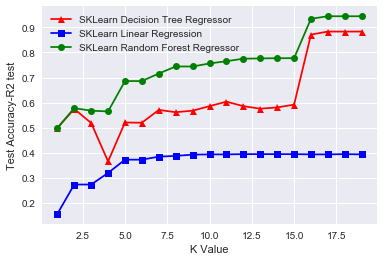

In [17]:
#visualize the model performance based on k parameter in SelectKBest
colors=["r","b","g"]
markers=["^","s","o"]
for l,c,m in zip(np.unique(expLog.iloc[:,0]),colors,markers):  
    plt.plot(expLog[expLog["Model description"]==l]["K"],
                expLog[expLog["Model description"]==l]["R2 test"],
                c=c,label=l,marker=m)
plt.xlabel("K Value")
plt.ylabel("Test Accuracy-R2 test")
plt.legend(loc="upper left")
plt.show()

## Kaggle test data prediction

### Test data preprocessing

In [18]:
#load data
test=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\test.csv')

#generate features from datetime
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})
#Obtain features
X_test=test.iloc[:,1:]
#Onehot Encoder for weather,season, year
X_test=onehotencoderhome(X_test,"weather")
X_test=onehotencoderhome(X_test,"season")
X_test=onehotencoderhome(X_test,"year")
X_test.head()

,holiday,workingday,temp,atemp,humidity,windspeed,hour,day,month,weather1,weather2,weather3,weather4,season1,season2,season3,season4,year0,year1
0,0,1,10.66,11.365,56,26.0027,0,3,1,1,0,0,0,1,0,0,0,1,0
1,0,1,10.66,13.635,56,0.0000,1,3,1,1,0,0,0,1,0,0,0,1,0
2,0,1,10.66,13.635,56,0.0000,2,3,1,1,0,0,0,1,0,0,0,1,0
3,0,1,10.66,12.880,56,11.0014,3,3,1,1,0,0,0,1,0,0,0,1,0
4,0,1,10.66,12.880,56,11.0014,4,3,1,1,0,0,0,1,0,0,0,1,0


### Prediction

In [19]:
#using best linear regression model to predict k=12
pipe_lr = Pipeline([
        ("std_scaler", StandardScaler()),
        ('feature_selection', SelectKBest(f_regression, k=12)),
        ('lineReg', LinearRegression())
    ])
pipe_lr.fit(X_train,y_train)
y_pred_lr=pipe_lr.predict(X_test)

#using best random forest model to predict k=17
forest = RandomForestRegressor(n_estimators = 400, criterion='mse',random_state=1, n_jobs=-1)
pipe_lr = Pipeline([
        ("std_scaler", StandardScaler()),
        ('feature_selection', SelectKBest(f_regression, k=17)),
        ('lineReg', forest)
    ])
pipe_lr.fit(X_train,y_train)
y_pred_rf=pipe_lr.predict(X_test)

In [21]:
#create submission file
df_submit = test
df_submit['count_rf'] = np.round(y_pred_rf) #using random forest prediction data
df_submit['count_lr'] = np.round(y_pred_lr) #using linear regression prediction data
#df_submit = df_submit.drop(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month','year'], axis=1)
df_submit = df_submit.drop(['season', 'holiday', 'workingday','weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month', 'year'], axis=1)
df_submit.head()

,datetime,count_rf,count_lr
0,2011-01-20 00:00:00,12.0,-39.0
1,2011-01-20 01:00:00,6.0,-33.0
2,2011-01-20 02:00:00,4.0,-26.0
3,2011-01-20 03:00:00,4.0,-17.0
4,2011-01-20 04:00:00,3.0,-9.0


### Clip all negative predictions at zero

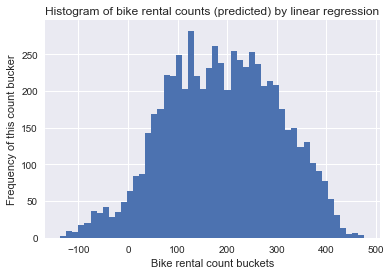

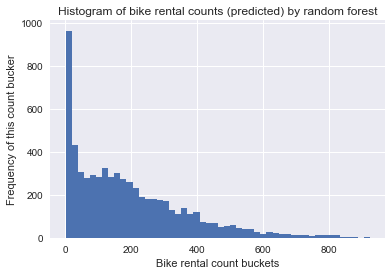

In [23]:
# Let's see how nagetive prediction from model
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(df_submit['count_lr'], 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title('Histogram of bike rental counts (predicted) by linear regression')
plt.grid(True)

plt.show()


# the histogram of the data
n, bins, patches = plt.hist(df_submit['count_rf'], 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title('Histogram of bike rental counts (predicted) by random forest')
plt.grid(True)

plt.show()

There are many negative predictions in linear regression model, no negative predictions in random forest.

In [25]:
#Let's clip all negative predictions at zero for linear regression model
df_submit['count_lr'] = np.where(df_submit['count_lr'] < 0, 0, df_submit['count_lr'])

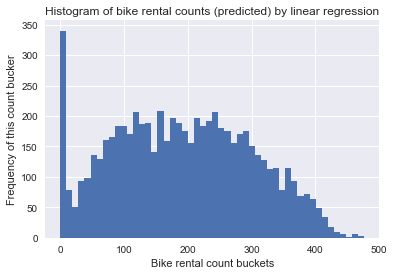

In [26]:
#double check from histgram
# the histogram of the data
n, bins, patches = plt.hist(df_submit['count_lr'], 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title('Histogram of bike rental counts (predicted) by linear regression')
plt.grid(True)

plt.show()

In [31]:
#Create submission file from linear regression model
df_submit[["datetime","count_lr"]].to_csv('bike_lr_jinjujiang.csv', index=False)
#Create submission file from random forest
df_submit[["datetime","count_rf"]].to_csv('bike_rf_jinjujiang.csv', index=False)

### Kaggle submission

Purely linear regression without log transformation does not perform very well in kaggle competition, the score is 1.32608.
However, the random forest model performed much better than linear regression, the public score is 0.48254.

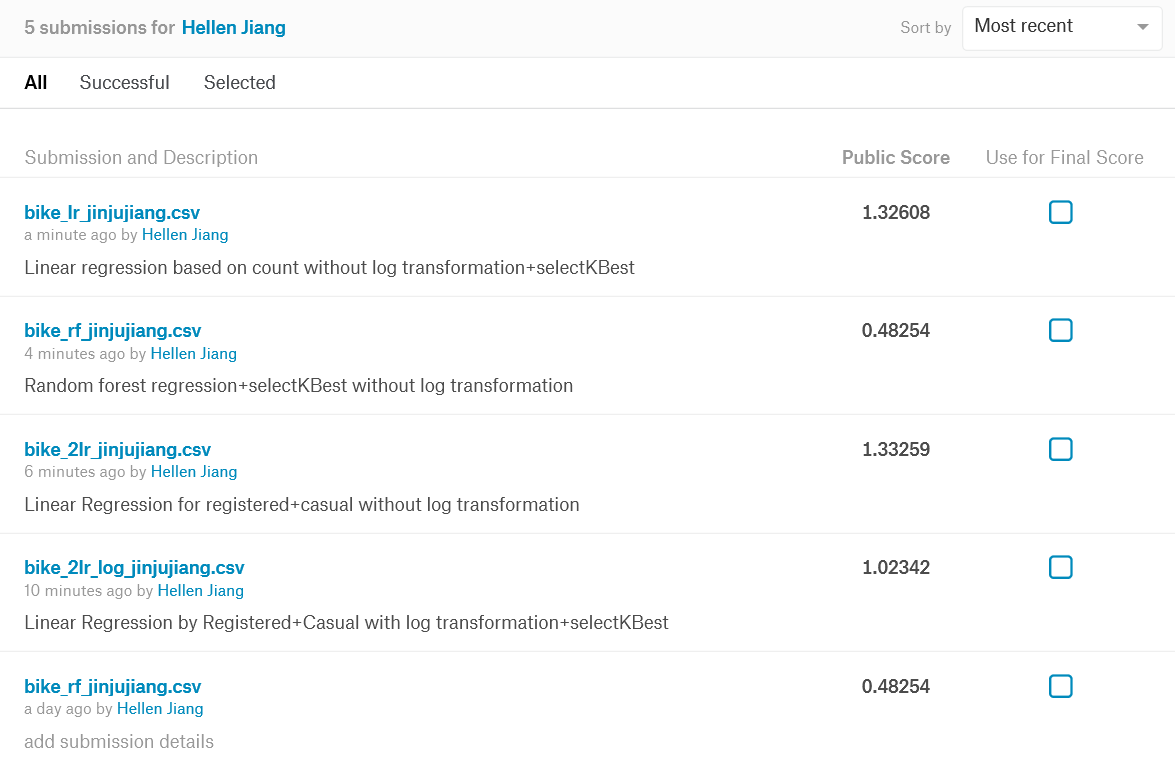

# Core task: bike demand extension 1 (2 separate LR models)

Build separate linear regression models for the other target variables (instead of the `count` target variable) and report your results:  

`
registered: number of registered user
casual:     number of non-registered user
`

Overall, we want you to build a linear regression model using pipelines that builds on what you learned as a solution to the previous section,   and do a Kaggle submission for this Bike Demand prediction problem. In particular, we want you to address (using what you have done previously) the following:

* Derive other features 
  * OHE features such as  season
  * Other derived features? [optional]
* Please do feature selection using `SelectKBest` 
  * See a full section on Feature Selection in Lab04 Notebook for details on how to do this. 
* Please put all modeling steps (including Feature Selection) in a Pipeline **(NOTE please keep the OHE step separate preprocessing step for this homework)**
* Present your experimental results in tabular form
  * Describe the linear regression model, number of input features used, MAE, RMSE and MAPE, feature familires used (e.g., Baseline features, Season OHE, etc.).
* Please do a Kaggle submission with your best linear regression model
* Screenshot your kaggle submission results
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). Were the selected features here the same as what you selected in your solution to Section 6? 


## Data Preprocessing

In [82]:
#load data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
train=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\train.csv')
#test=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\test.csv')
#Transform datetime into year,month,day,hour
train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): based 
#Define onehot encoder function
def onehotencoderhome(traindata,feature):
    # Create a new column called df.weather1 where the value is 1
    # if df.weather is 1 and 0 if not
    for f in np.unique(traindata[feature]):
        newfeature=feature+str(f)
        traindata[newfeature] = np.where(traindata[feature]==f, 1, 0)

    #drop the original feature    
    return traindata.drop(feature, axis=1)
#Onehot Encoder for weather,season, year
train=onehotencoderhome(train,"weather")
train=onehotencoderhome(train,"season")
train=onehotencoderhome(train,"year")
train.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,...,weather1,weather2,weather3,weather4,season1,season2,season3,season4,year0,year1
0,2011-01-01 00:00:00,0,0,9.84,14.395,81,0.0,3,13,16,...,1,0,0,0,1,0,0,0,1,0
1,2011-01-01 01:00:00,0,0,9.02,13.635,80,0.0,8,32,40,...,1,0,0,0,1,0,0,0,1,0
2,2011-01-01 02:00:00,0,0,9.02,13.635,80,0.0,5,27,32,...,1,0,0,0,1,0,0,0,1,0
3,2011-01-01 03:00:00,0,0,9.84,14.395,75,0.0,3,10,13,...,1,0,0,0,1,0,0,0,1,0
4,2011-01-01 04:00:00,0,0,9.84,14.395,75,0.0,0,1,1,...,1,0,0,0,1,0,0,0,1,0


In [83]:
#Separate input features and target feature
#X=features,y=target, and drop unnecessary features
y_r =train['registered'] #register is target
y_c =train['casual'] #casual is target
X = train.drop(['datetime','registered', 'casual', 'count'], axis=1)
#double check the data
X.iloc[0:2,:]

,holiday,workingday,temp,atemp,humidity,windspeed,hour,day,month,weather1,weather2,weather3,weather4,season1,season2,season3,season4,year0,year1
0,0,0,9.84,14.395,81,0.0,0,5,1,1,0,0,0,1,0,0,0,1,0
1,0,0,9.02,13.635,80,0.0,1,5,1,1,0,0,0,1,0,0,0,1,0


In [84]:
#split training dataset into training and test parts
from sklearn.cross_validation import  train_test_split
X_train, X_test, y_c_train, y_c_test,y_r_train,y_r_test = train_test_split(X, y_c,y_r, test_size=.3, random_state=0)
print("training datasets:",X_train.shape)
print("Validate datasets:",X_test.shape)
print("training datasets:",y_c_train.shape)
print("Validate datasets:",y_c_test.shape)
print("training datasets:",y_r_train.shape)
print("Validate datasets:",y_r_test.shape)

training datasets: (7620, 19)
Validate datasets: (3266, 19)
training datasets: (7620,)
Validate datasets: (3266,)
training datasets: (7620,)
Validate datasets: (3266,)


## Feature importance

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

# SCORE  linear regression input variables using correlation producing F scores and corresponding p-values
# K is used select top k rated input features
def select_kbest_reg(data_frame, target, k=5):
    """
    Selecting K-Best features regression
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_regression, k=k)
    _ = feat_selector.fit(data_frame, target)
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.columns
    
    return feat_scores


### Target value -registered

In [36]:
per_feat=select_kbest_reg(X_train,y_c_train,k=7)
per_feat_sorted=per_feat.sort_values(["F Score","P Value"],ascending=[False,False])
top_k_feature_indices=per_feat_sorted["Attribute"].values.flatten()
feature_importances = per_feat[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances_sorted = per_feat_sorted[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances

,F Score,Attribute
0,16.606019,holiday
1,841.617133,workingday
2,2185.595067,temp
3,2120.362611,atemp
4,1014.044057,humidity
5,64.076278,windspeed
6,780.018610,hour
7,451.598301,day
8,69.897154,month
9,90.701218,weather1


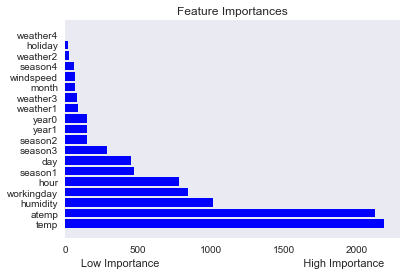

In [37]:
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure() 
plt.title("Feature importances")
sortedNames = np.array(feature_importances_sorted)[:, 1]
sortedImportances = np.array(feature_importances_sorted)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Low Importance                                                High Importance')
plt.grid()
plt.show()

### Target value-casual

In [38]:
per_feat=select_kbest_reg(X_train,y_r_train,k=7)
per_feat_sorted=per_feat.sort_values(["F Score","P Value"],ascending=[False,False])
top_k_feature_indices=per_feat_sorted["Attribute"].values.flatten()
feature_importances = per_feat[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances_sorted = per_feat_sorted[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances

,F Score,Attribute
0,2.416684,holiday
1,115.906246,workingday
2,843.176752,temp
3,813.639983,atemp
4,570.319498,humidity
5,61.252272,windspeed
6,1296.800472,hour
7,71.362797,day
8,237.504136,month
9,62.484946,weather1


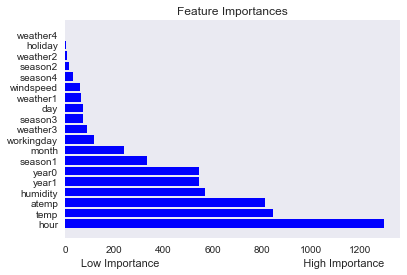

In [39]:
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure() 
plt.title("Feature importances")
sortedNames = np.array(feature_importances_sorted)[:, 1]
sortedImportances = np.array(feature_importances_sorted)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Low Importance                                                High Importance')
plt.grid()
plt.show()

### Feature importance is different for different target(registered,casual)

## Pipeline with log transformation

In [57]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
def rmsle(y,y_):
    log1=np.nan_to_num(np.array([np.log(v+1) for v in y]))
    log2=np.nan_to_num(np.array([np.log(v+1) for v in y_]))
    calc=(log1-log2)**2
    return np.sqrt(np.mean(calc))

In [58]:
#keep a log book to track experiments
expLog = pd.DataFrame(columns=["Model description","Target","K","RMSLE train", 'RMSLE test','R2 train','R2 test'])

### Linear Regression model

In [59]:
model_name="SKLearn Linear Regression_log"
y_r_train_log=np.nan_to_num(np.array([np.log(v+1) for v in y_r_train]))
y_c_train_log=np.nan_to_num(np.array([np.log(v+1) for v in y_c_train]))
for i in range(1,X_train.shape[1]+1):
    pipe_lr = Pipeline([
            ("std_scaler", StandardScaler()),
            ('feature_selection', SelectKBest(f_regression, k=i)),
            ('lineReg', LinearRegression())
        ])
    for ta in (["Registered","Casual"]):
        if ta=="Registered":
            y_train=y_r_train
            y_test=y_r_test
            y_train_log=y_r_train_log
        else:
            y_train=y_c_train
            y_test=y_c_test
            y_train_log=y_c_train_log
        pipe_lr.fit(X_train,y_train_log)
        y_train_pred_log=pipe_lr.predict(X_train)
        y_test_pred_log=pipe_lr.predict(X_test)
        y_train_pred=np.nan_to_num(np.array([np.e**(v)-1 for v in y_train_pred_log]))
        y_test_pred=np.nan_to_num(np.array([np.e**(v)-1 for v in y_test_pred_log]))
        #print("Test Accuracy: %.3f" % pipe_lr.score(X_test,y_test))
        # add the result of this experiment ot the log book
        expLog.loc[len(expLog)] = [model_name,ta,i,  
                        np.round(rmsle(y_train, y_train_pred), 3),
                        np.round(rmsle(y_test, y_test_pred),3),
                        np.round(r2_score(y_train, y_train_pred), 3),
                        np.round(r2_score(y_test, y_test_pred), 3)]
expLog

,Model description,Target,K,RMSLE train,RMSLE test,R2 train,R2 test
0,SKLearn Linear Regression_log,Registered,1,1.146,1.151,-0.135,-0.162
1,SKLearn Linear Regression_log,Casual,1,1.231,1.237,0.099,0.079
2,SKLearn Linear Regression_log,Registered,2,1.092,1.093,-0.008,-0.032
3,SKLearn Linear Regression_log,Casual,2,1.230,1.236,0.098,0.078
4,SKLearn Linear Regression_log,Registered,3,1.092,1.093,-0.008,-0.032
5,SKLearn Linear Regression_log,Casual,3,1.066,1.078,0.163,0.126
6,SKLearn Linear Regression_log,Registered,4,1.069,1.069,0.073,0.039
7,SKLearn Linear Regression_log,Casual,4,1.010,1.013,0.244,0.193
8,SKLearn Linear Regression_log,Registered,5,1.058,1.061,0.087,0.051
9,SKLearn Linear Regression_log,Casual,5,0.998,1.004,0.263,0.208


For casual prediction, the best k=16, for registered prediction,the best k=17. For both of them,the feature selection is different with previous feature selection for count prediction.

### Visualize linear regression model results

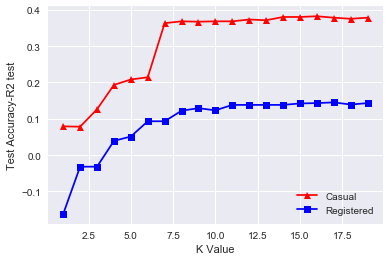

In [60]:
#visualize the model performance
colors=["r","b"]
markers=["^","s"]
for l,c,m in zip(np.unique(expLog["Target"]),colors,markers):  
    plt.plot(expLog[expLog["Target"]==l]["K"],
                expLog[expLog["Target"]==l]["R2 test"],
                c=c,label=l,marker=m)
plt.xlabel("K Value")
plt.ylabel("Test Accuracy-R2 test")
plt.legend(loc="lower right")
plt.show()

## Kaggle test data prediction with log transformation

### Data preprocessing

In [85]:
#load data
test=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\test.csv')

#generate features from datetime
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})
#Obtain features
X_test=test.iloc[:,1:]
#Onehot Encoder for weather,season, year
X_test=onehotencoderhome(X_test,"weather")
X_test=onehotencoderhome(X_test,"season")
X_test=onehotencoderhome(X_test,"year")
X_test.head()

,holiday,workingday,temp,atemp,humidity,windspeed,hour,day,month,weather1,weather2,weather3,weather4,season1,season2,season3,season4,year0,year1
0,0,1,10.66,11.365,56,26.0027,0,3,1,1,0,0,0,1,0,0,0,1,0
1,0,1,10.66,13.635,56,0.0000,1,3,1,1,0,0,0,1,0,0,0,1,0
2,0,1,10.66,13.635,56,0.0000,2,3,1,1,0,0,0,1,0,0,0,1,0
3,0,1,10.66,12.880,56,11.0014,3,3,1,1,0,0,0,1,0,0,0,1,0
4,0,1,10.66,12.880,56,11.0014,4,3,1,1,0,0,0,1,0,0,0,1,0


### Prediction

In [86]:
#using best linear regression model to predict k=16 for casual, and k=17 for registered prediction

log_y_r_train=np.nan_to_num(np.array([np.log(v+1) for v in y_r_train]))
log_y_c_train=np.nan_to_num(np.array([np.log(v+1) for v in y_c_train]))

pipe_lr_r = Pipeline([
        ("std_scaler", StandardScaler()),
        ('feature_selection', SelectKBest(f_regression, k=17)),
        ('lineReg', LinearRegression())
    ])

pipe_lr_r.fit(X_train,log_y_r_train)
y_pred_lr_r_log=pipe_lr_r.predict(X_test)
y_pred_lr_r=np.nan_to_num(np.array([np.e**(v)-1 for v in y_pred_lr_r_log]))

pipe_lr_c = Pipeline([
        ("std_scaler", StandardScaler()),
        ('feature_selection', SelectKBest(f_regression, k=16)),
        ('lineReg', LinearRegression())
    ])
pipe_lr_c.fit(X_train,log_y_c_train)
y_pred_lr_c_log=pipe_lr_c.predict(X_test)
y_pred_lr_c=np.nan_to_num(np.array([np.e**(v)-1 for v in y_pred_lr_c_log]))

In [87]:
#create submission file
df_submit = test
df_submit['registered'] = np.round(y_pred_lr_r)
df_submit['casual'] = np.round(y_pred_lr_c)
#df_submit = df_submit.drop(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month','year'], axis=1)
df_submit = df_submit.drop(['season', 'holiday', 'workingday','weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month', 'year'], axis=1)
df_submit['count']=df_submit['registered']+df_submit['casual']
df_submit.head()

,datetime,registered,casual,count
0,2011-01-20 00:00:00,11.0,1.0,12.0
1,2011-01-20 01:00:00,11.0,1.0,12.0
2,2011-01-20 02:00:00,12.0,1.0,13.0
3,2011-01-20 03:00:00,14.0,1.0,15.0
4,2011-01-20 04:00:00,16.0,1.0,17.0


In [88]:
#Let's verify whether there is negative count
np.unique(np.where(df_submit["count"]<0,1,0))

array([0])

The result shows there is no negative count prediction

In [89]:
#Create submission file
df_submit[["datetime","count"]].to_csv('bike_2lr_log_jinjujiang.csv', index=False)

### Kaggle Submission

After log transformation on registered and casual, the linear regression performed better than the model withouting log transformation.
The score for 2 predictions with log transformation is 1.02342. the score for 2 predictions without log transformation is 1.33259, so far it is the worst prediction.

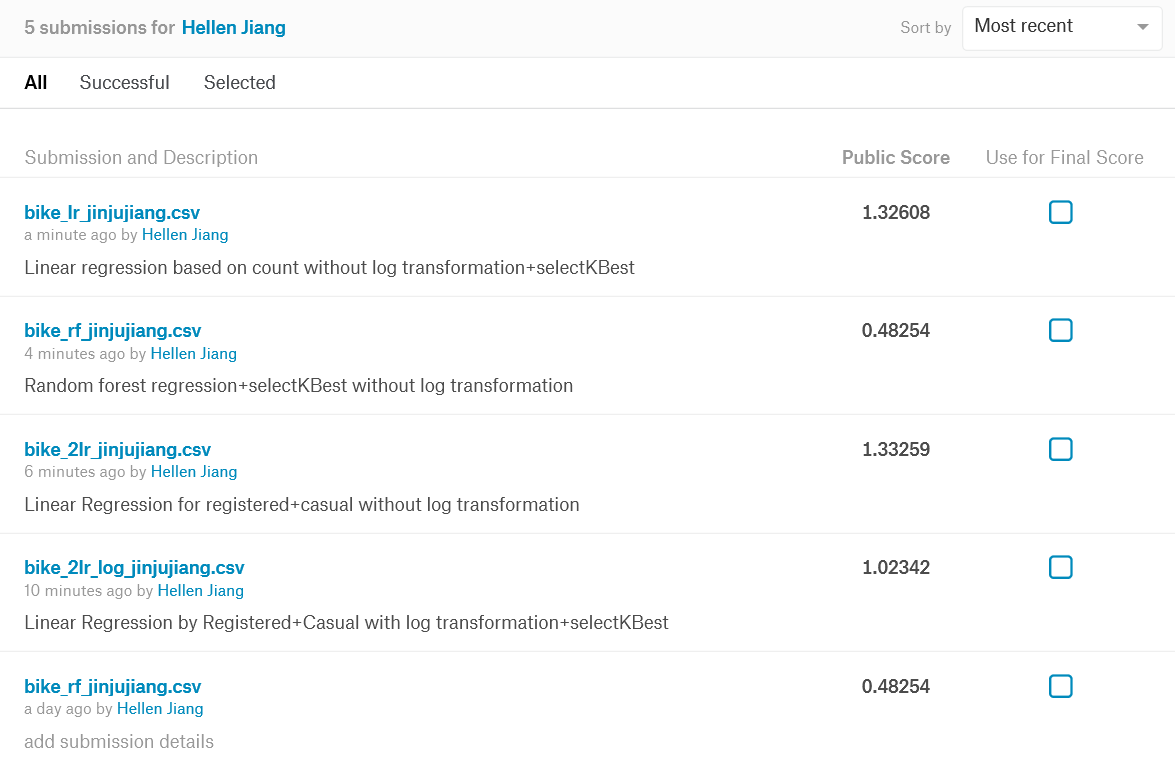

## Prediction without log transformation

### Data Preprocess

In [70]:
#load data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
train=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\train.csv')
#test=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\test.csv')
#Transform datetime into year,month,day,hour
train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): based 
#Define onehot encoder function
def onehotencoderhome(traindata,feature):
    # Create a new column called df.weather1 where the value is 1
    # if df.weather is 1 and 0 if not
    for f in np.unique(traindata[feature]):
        newfeature=feature+str(f)
        traindata[newfeature] = np.where(traindata[feature]==f, 1, 0)

    #drop the original feature    
    return traindata.drop(feature, axis=1)
#Onehot Encoder for weather,season, year
train=onehotencoderhome(train,"weather")
train=onehotencoderhome(train,"season")
train=onehotencoderhome(train,"year")
#Separate input features and target feature
#X=features,y=target, and drop unnecessary features
y_r =train['registered'] #register is target
y_c =train['casual'] #casual is target
X = train.drop(['datetime','registered', 'casual', 'count'], axis=1)
#split training dataset into training and test parts
from sklearn.cross_validation import  train_test_split
X_train, X_test, y_c_train, y_c_test,y_r_train,y_r_test = train_test_split(X, y_c,y_r, test_size=.3, random_state=0)


### Pipeline without log

#### Linear Regression Model

In [71]:
#keep a log book to track experiments
expLog = pd.DataFrame(columns=["Model description","Target","K","RMSLE train", 'RMSLE test','R2 train','R2 test'])

In [72]:
model_name="SKLearn Linear Regression_2lr_withoutlog"
for i in range(1,X_train.shape[1]+1):
    pipe_lr = Pipeline([
            ("std_scaler", StandardScaler()),
            ('feature_selection', SelectKBest(f_regression, k=i)),
            ('lineReg', LinearRegression())
        ])
    for ta in (["Registered","Casual"]):
        if ta=="Registered":
            y_train=y_r_train
            y_test=y_r_test
        else:
            y_train=y_c_train
            y_test=y_c_test
        pipe_lr.fit(X_train,y_train)
        y_train_pred=pipe_lr.predict(X_train)
        y_test_pred=pipe_lr.predict(X_test)
        # add the result of this experiment ot the log book
        expLog.loc[len(expLog)] = [model_name,ta,i,  
                        np.round(rmsle(y_train, y_train_pred), 3),
                        np.round(rmsle(y_test, y_test_pred),3),
                        np.round(r2_score(y_train, y_train_pred), 3),
                        np.round(r2_score(y_test, y_test_pred), 3)]
expLog

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\hjiang

,Model description,Target,K,RMSLE train,RMSLE test,R2 train,R2 test
0,SKLearn Linear Regression_2lr_withoutlog,Registered,1,1.319,1.312,0.145,0.143
1,SKLearn Linear Regression_2lr_withoutlog,Casual,1,1.421,1.427,0.223,0.207
2,SKLearn Linear Regression_2lr_withoutlog,Registered,2,1.247,1.241,0.215,0.217
3,SKLearn Linear Regression_2lr_withoutlog,Casual,2,1.421,1.430,0.223,0.207
4,SKLearn Linear Regression_2lr_withoutlog,Registered,3,1.247,1.242,0.215,0.217
5,SKLearn Linear Regression_2lr_withoutlog,Casual,3,1.364,1.333,0.324,0.318
6,SKLearn Linear Regression_2lr_withoutlog,Registered,4,1.225,1.211,0.241,0.243
7,SKLearn Linear Regression_2lr_withoutlog,Casual,4,1.378,1.329,0.431,0.440
8,SKLearn Linear Regression_2lr_withoutlog,Registered,5,1.248,1.250,0.296,0.303
9,SKLearn Linear Regression_2lr_withoutlog,Casual,5,1.276,1.243,0.457,0.460


Best parameter k=10 for casual prediction, k=15 for registered prediction

#### Visualize model performance

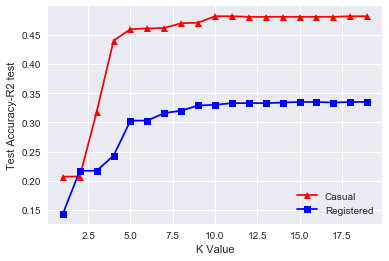

In [73]:
#visualize the model performance
colors=["r","b"]
markers=["^","s"]
for l,c,m in zip(np.unique(expLog["Target"]),colors,markers):  
    plt.plot(expLog[expLog["Target"]==l]["K"],
                expLog[expLog["Target"]==l]["R2 test"],
                c=c,label=l,marker=m)
plt.xlabel("K Value")
plt.ylabel("Test Accuracy-R2 test")
plt.legend(loc="lower right")
plt.show()

### Kaggle test data prediction and submission

#### Kaggle test data prediction

In [74]:
#load data
test=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\test.csv')

#generate features from datetime
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})
#Obtain features
X_test=test.iloc[:,1:]
#Onehot Encoder for weather,season, year
X_test=onehotencoderhome(X_test,"weather")
X_test=onehotencoderhome(X_test,"season")
X_test=onehotencoderhome(X_test,"year")

In [75]:
#using best linear regression model to predict k=10 for casual prediction and 15 for register prediction
pipe_lr = Pipeline([
        ("std_scaler", StandardScaler()),
        ('feature_selection', SelectKBest(f_regression, k=10)),
        ('lineReg', LinearRegression())
    ])
pipe_lr.fit(X_train,y_c_train)
y_pred_lr_c=pipe_lr.predict(X_test)


pipe_lr = Pipeline([
        ("std_scaler", StandardScaler()),
        ('feature_selection', SelectKBest(f_regression, k=15)),
        ('lineReg', LinearRegression())
    ])
pipe_lr.fit(X_train,y_r_train)
y_pred_lr_r=pipe_lr.predict(X_test)


In [76]:
#create submission file
df_submit = test
df_submit['registered'] = np.round(y_pred_lr_r)
df_submit['casual'] = np.round(y_pred_lr_c)
#df_submit = df_submit.drop(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month','year'], axis=1)
df_submit = df_submit.drop(['season', 'holiday', 'workingday','weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month', 'year'], axis=1)
df_submit['count']=df_submit['registered']+df_submit['casual']
df_submit.head()

,datetime,registered,casual,count
0,2011-01-20 00:00:00,-16.0,-20.0,-36.0
1,2011-01-20 01:00:00,-15.0,-17.0,-32.0
2,2011-01-20 02:00:00,-8.0,-16.0,-24.0
3,2011-01-20 03:00:00,1.0,-16.0,-15.0
4,2011-01-20 04:00:00,7.0,-14.0,-7.0


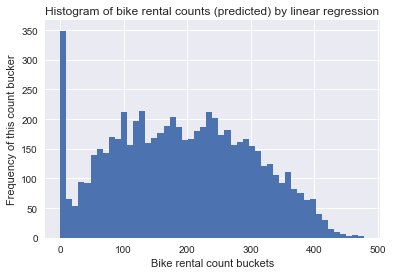

In [77]:
#Let's clip all negative predictions at zero for linear regression model
df_submit['count'] = np.where(df_submit['count'] < 0, 0, df_submit['count'])

#double check from histgram
# the histogram of the data
n, bins, patches = plt.hist(df_submit['count'], 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title('Histogram of bike rental counts (predicted) by linear regression')
plt.grid(True)

plt.show()

In [78]:
#Create submission file
df_submit[["datetime","count"]].to_csv('bike_2lr_jinjujiang.csv', index=False)

#### Kaggle submission

Seperately prediction for registered and casual without log transformation performed the worst. the score is 1.33259

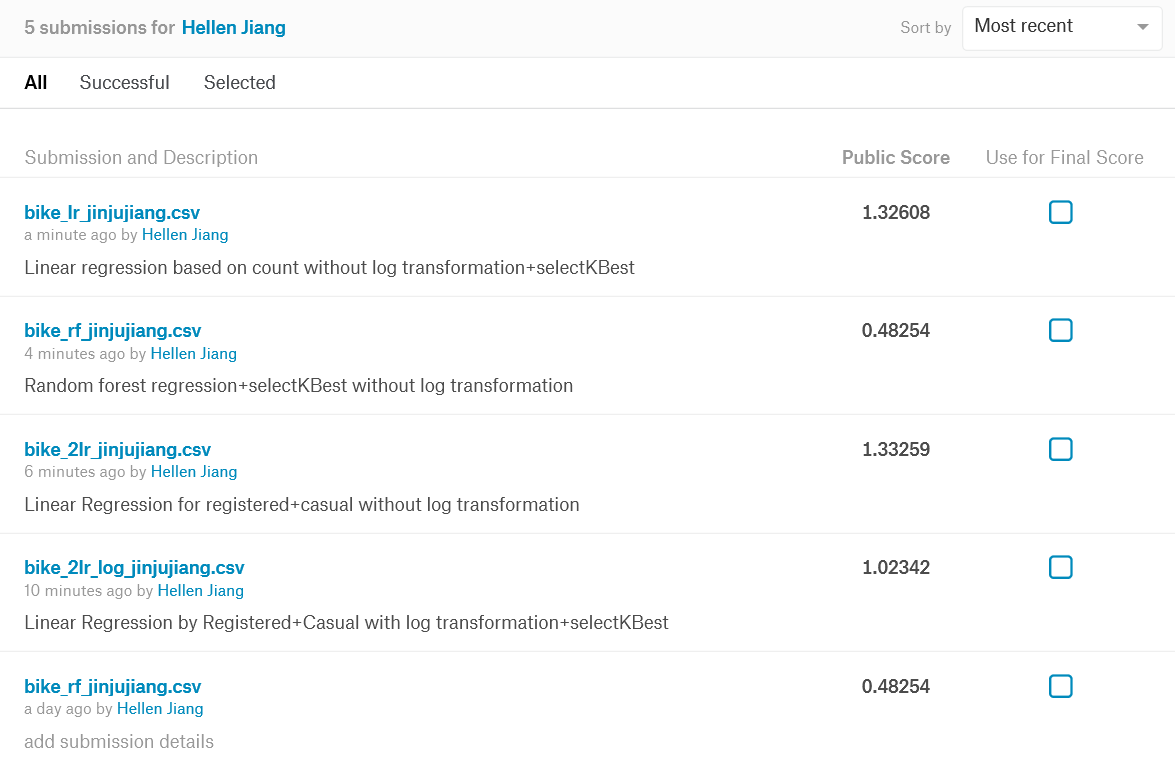

# Core task: bike demand extension 2 (target = log(demand+1))

** This question is in draft mode ** Final version will appear on June 7, 2018

The distribution of the raw `count` feature is very skewed with most values occuring to the left of the count domain. To make this distribution less skewed (and more normal distributed, it is common to take the log of the value + 1 (to avoid log(0)). 

* log(count+1)

Overall, we want you to build a linear regression model (single model will suffice based on the `count` target) using pipelines that builds on what you learned as a solution to the previous section,   and do a Kaggle submission for this Bike Demand prediction problem. In particular, we want you to address (using what you have done previously) the following:

* Derive other features 
  * OHE features such as  season, 
  * If barplot demand over each hour of the the day, you will notice interesting patterns. E.g., you might be able to  segregate the bike demand in three hourly categories, like the following:

      ```
         High       : 7-9 and 17-19 hours
         Average    : 10-16 hours
         Low        : 0-6 and 20-24 hours
```
* Perform feature selection using `Sequential Backward Selection` algorithm
  * See a full section on Sequential Backward Selection for regression in Lab05 Notebook for details on how to do this. 
* Please put all modeling steps in a Pipeline 
  * NOTE please keep the OHE step separate preprocessing step for this homework
  * Feature Selection can be performed prior to the pipeline or as part of the pipeline. Please discuss what you choose and why.
* Present your experimental results in tabular form
  * Describe the linear regression model, number of input features used, MAE, RMSE and MAPE, feature familires used (e.g., Baseline features, Season OHE, etc.).
* Please do a Kaggle submission with your best linear regression model
* Screenshot your kaggle submission results
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). Were the selected features here the same as what you selected in your solution to Section 6? 



## Data Preprocessing

### Data Loading

In [1]:
#load data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
train=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\train.csv')


### Derive new features

#### OHE

In [2]:
#Transform datetime into year,month,day,hour
train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): based 
#Define onehot encoder function
def onehotencoderhome(traindata,feature):
    # Create a new column called df.weather1 where the value is 1
    # if df.weather is 1 and 0 if not
    for f in np.unique(traindata[feature]):
        newfeature=feature+str(f)
        traindata[newfeature] = np.where(traindata[feature]==f, 1, 0)

    #drop the original feature    
    return traindata.drop(feature, axis=1)
#Onehot Encoder for weather,season, year
train=onehotencoderhome(train,"weather")
train=onehotencoderhome(train,"season")
train=onehotencoderhome(train,"year")
train.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,...,weather1,weather2,weather3,weather4,season1,season2,season3,season4,year0,year1
0,2011-01-01 00:00:00,0,0,9.84,14.395,81,0.0,3,13,16,...,1,0,0,0,1,0,0,0,1,0
1,2011-01-01 01:00:00,0,0,9.02,13.635,80,0.0,8,32,40,...,1,0,0,0,1,0,0,0,1,0
2,2011-01-01 02:00:00,0,0,9.02,13.635,80,0.0,5,27,32,...,1,0,0,0,1,0,0,0,1,0
3,2011-01-01 03:00:00,0,0,9.84,14.395,75,0.0,3,10,13,...,1,0,0,0,1,0,0,0,1,0
4,2011-01-01 04:00:00,0,0,9.84,14.395,75,0.0,0,1,1,...,1,0,0,0,1,0,0,0,1,0


#### Derive new category based on hour feature

In [3]:
# Create a new column called df.hour1 where the value is 1
'''
    hour3-High       : 7-9 and 17-19 hours
     hour2-Average    : 10-16 hours
     hour1-Low        : 0-6 and 20-24 hours'''

train['hour1'] = np.where((((train['hour']>=0)&(train['hour']<=6))|((train['hour']>=20)&(train['hour']<=24))), 1, 0)
train['hour3'] = np.where((((train['hour']>=7)&(train['hour']<=9))|((train['hour']>=17)&(train['hour']<=19))), 1, 0)
train['hour2'] = np.where(((train['hour']>=10)&(train['hour']<=16)), 1, 0)

# dont forget to drop the original feature
train=train.drop(['hour'], axis=1)

### Features and target

#### Separte X and y

In [4]:
#X=features,y=target
y =train['count']
X = train.drop(['datetime','registered', 'casual', 'count'], axis=1)
#double check the data
X.iloc[0:2,:]
#split training dataset into training and test parts
from sklearn.cross_validation import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
print("training datasets:",X_train.shape)
print("Validate datasets:",X_test.shape)

training datasets: (7620, 21)
Validate datasets: (3266, 21)


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Transform y_train by log function

In [5]:
log_y_train=np.nan_to_num(np.array([np.log(v+1) for v in y_train]))

## Feature Importance

 1) hour1                          0.412123
 2) humidity                       0.109038
 3) temp                           0.100920
 4) windspeed                      0.074331
 5) atemp                          0.061260
 6) day                            0.058621
 7) month                          0.057898
 8) workingday                     0.021681
 9) year0                          0.021562
10) year1                          0.018165
11) weather3                       0.010128
12) weather2                       0.009885
13) weather1                       0.009377
14) hour2                          0.007781
15) hour3                          0.007746
16) season4                        0.004959
17) season1                        0.004893
18) season2                        0.004383
19) season3                        0.003453
20) holiday                        0.001793
21) weather4                       0.000003


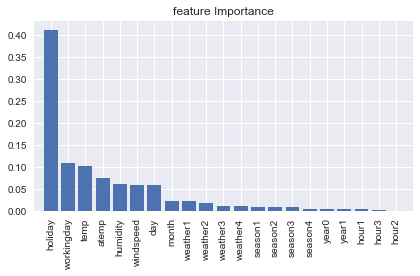

In [6]:
from sklearn.ensemble import RandomForestRegressor
feat_labels=X_train.columns[0:]
forest=RandomForestRegressor(n_estimators=500,random_state=1)
forest.fit(X_train,log_y_train)
importances=forest.feature_importances_
indices=np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) % -*s %f" %(f+1,30,
                          feat_labels[indices[f]],
                          importances[indices[f]]))
plt.title("feature Importance")
plt.bar(range(X_train.shape[1]),
       importances[indices],
       align="center")
plt.xticks(range(X_train.shape[1]),
          feat_labels,rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.show()

## Learn Linear Regression Model

### Feature Selection SBS

In [4]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        #split training data into train and validation subsets
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []
            # look at all combinations of dim-1 features 
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        ## TODO  please complete!
        # using crossfold validation select the single best model from among all selected subsets
        # using cross-validated performance utility
        
        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

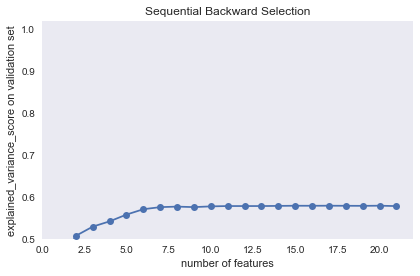

In [9]:

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

lr =LinearRegression()

# selecting features
sbs = SBS(lr, k_features=1, scoring=explained_variance_score)
sbs.fit(X_train_std, log_y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

#plot places the points on the graph using the number of features (no need to sort!)
plt.plot(k_feat, sbs.scores_, marker='o')  
plt.ylim([0.5, 1.02])
plt.title("Sequential Backward Selection")
plt.ylabel('explained_variance_score on validation set')
plt.xlabel(r'number of features')
plt.grid()
plt.tight_layout()
plt.show()


In [10]:
#show the feature subsets that were selected in backward elimination fashion
list(zip( np.arange(0, len(sbs.scores_)), k_feat, np.round(sbs.scores_, 3), sbs.subsets_)  )

[(0,
  21,
  0.57799999999999996,
  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)),
 (1,
  20,
  0.57899999999999996,
  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)),
 (2,
  19,
  0.57899999999999996,
  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19)),
 (3,
  18,
  0.57899999999999996,
  (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19)),
 (4,
  17,
  0.57899999999999996,
  (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19)),
 (5,
  16,
  0.57899999999999996,
  (0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19)),
 (6,
  15,
  0.57899999999999996,
  (0, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19)),
 (7,
  14,
  0.57799999999999996,
  (2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19)),
 (8, 13, 0.57799999999999996, (2, 4, 6, 7, 9, 10, 11, 12, 13, 15, 16, 18, 19)),
 (9, 12, 0.57799999999999996, (2, 4, 6, 7, 9, 10, 12, 13, 15, 16, 18, 19)),
 (10, 11, 0.57799999999999996, (2, 4, 6, 

In [11]:
best_subset = list(sbs.subsets_[6])
best_subset

[0, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19]

In [12]:
#selected best column name by SBS
subsets_column=X_train.columns[:][best_subset]
subsets_column

Index(['holiday', 'temp', 'humidity', 'day', 'month', 'weather1', 'weather2',
       'weather3', 'weather4', 'season1', 'season2', 'season4', 'year0',
       'hour1', 'hour3'],
      dtype='object')

### Pipeline

In [13]:
def rmsle(y,y_):
    log1=np.nan_to_num(np.array([np.log(v+1) for v in y]))
    log2=np.nan_to_num(np.array([np.log(v+1) for v in y_]))
    calc=(log1-log2)**2
    return np.sqrt(np.mean(calc))
#keep a log book to track experiments
expLog = pd.DataFrame(columns=["Model description","K","RMSLE train", 'RMSLE test','R2 train','R2 test'])

In [14]:
model_name="SKLearn Linear Regression_log"
for i in range(0,X_train.shape[1]):
    pipe_lr = Pipeline([
            ("std_scaler", StandardScaler()),
            ('lineReg', LinearRegression())
        ])
    best_subsets_index = list(sbs.subsets_[i])
    subsets_column=X_train.columns[:][best_subsets_index]
    #X_train.loc[:,subsets_column]
   # X_train[:, best_k_subsets].head()
    pipe_lr.fit(X_train.loc[:,subsets_column],log_y_train)
    y_train_pred_log=pipe_lr.predict(X_train.loc[:,subsets_column])
    y_test_pred_log=pipe_lr.predict(X_test.loc[:,subsets_column])
    y_train_pred=np.nan_to_num(np.array([np.e**(v)-1 for v in y_train_pred_log]))
    y_test_pred=np.nan_to_num(np.array([np.e**(v)-1 for v in y_test_pred_log]))
    # add the result of this experiment ot the log book
    expLog.loc[len(expLog)] = [model_name,i,  
                    np.round(rmsle(y_train, y_train_pred), 3),
                    np.round(rmsle(y_test, y_test_pred),3),
                    np.round(r2_score(y_train, y_train_pred), 3),
                    np.round(r2_score(y_test, y_test_pred), 3)]
expLog

,Model description,K,RMSLE train,RMSLE test,R2 train,R2 test
0,SKLearn Linear Regression_log,0,0.934,0.935,0.544,0.510
1,SKLearn Linear Regression_log,1,0.934,0.934,0.546,0.512
2,SKLearn Linear Regression_log,2,0.934,0.935,0.546,0.512
3,SKLearn Linear Regression_log,3,0.934,0.935,0.549,0.516
4,SKLearn Linear Regression_log,4,0.934,0.934,0.545,0.511
5,SKLearn Linear Regression_log,5,0.934,0.935,0.545,0.509
6,SKLearn Linear Regression_log,6,0.934,0.936,0.539,0.504
7,SKLearn Linear Regression_log,7,0.935,0.936,0.541,0.505
8,SKLearn Linear Regression_log,8,0.934,0.936,0.541,0.505
9,SKLearn Linear Regression_log,9,0.934,0.936,0.541,0.505


From the above results, it looks like that k_features=21-3=18 performed better than k_features=21-6=15. Let's explore which one performed better in kaggle test data prediction

## Kaggle Test Data Prediction

### Prediction with best model(k=3, and k=6)

In [15]:
#load data
test=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\test.csv')

#generate features from datetime
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})
#Obtain features
X_test=test.iloc[:,1:]
#Onehot Encoder for weather,season, year
X_test=onehotencoderhome(X_test,"weather")
X_test=onehotencoderhome(X_test,"season")
X_test=onehotencoderhome(X_test,"year")

In [16]:
# Create a new column called df.hour1 where the value is 1
'''
    hour3-High       : 7-9 and 17-19 hours
     hour2-Average    : 10-16 hours
     hour1-Low        : 0-6 and 20-24 hours'''

X_test['hour1'] = np.where((((X_test['hour']>=0)&(X_test['hour']<=6))|((X_test['hour']>=20)&(X_test['hour']<=24))), 1, 0)
X_test['hour3'] = np.where((((X_test['hour']>=7)&(X_test['hour']<=9))|((X_test['hour']>=17)&(X_test['hour']<=19))), 1, 0)
X_test['hour2'] = np.where(((X_test['hour']>=10)&(X_test['hour']<=16)), 1, 0)

# dont forget to drop the original feature
X_test=X_test.drop(['hour'], axis=1)

In [17]:
X_test.head()

,holiday,workingday,temp,atemp,humidity,windspeed,day,month,weather1,weather2,...,weather4,season1,season2,season3,season4,year0,year1,hour1,hour3,hour2
0,0,1,10.66,11.365,56,26.0027,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0
1,0,1,10.66,13.635,56,0.0000,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0
2,0,1,10.66,13.635,56,0.0000,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0
3,0,1,10.66,12.880,56,11.0014,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0
4,0,1,10.66,12.880,56,11.0014,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0


In [25]:
df_submit = test
df_submit = df_submit.drop(['season', 'holiday', 'workingday','weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month', 'year'], axis=1)
for i in (3,6):
    pipe_lr = Pipeline([
            ("std_scaler", StandardScaler()),
            ('lineReg', LinearRegression())
        ])
    best_subsets_index = list(sbs.subsets_[i])
    subsets_column=X_train.columns[:][best_subsets_index]
    pipe_lr.fit(X_train.loc[:,subsets_column],log_y_train)
    y_test_pred_log=pipe_lr.predict(X_test.loc[:,subsets_column])
    y_test_pred=np.nan_to_num(np.array([np.e**(v)-1 for v in y_test_pred_log]))
    df_submit['count'+str(i)] = np.round(y_test_pred)
df_submit.head()

,datetime,count3,count6
0,2011-01-20 00:00:00,16.0,16.0
1,2011-01-20 01:00:00,16.0,16.0
2,2011-01-20 02:00:00,16.0,16.0
3,2011-01-20 03:00:00,16.0,16.0
4,2011-01-20 04:00:00,16.0,16.0


In [27]:
#create submission file
df_submit[["datetime","count3"]].to_csv('bike_lr_log_3_jinjujiang.csv', index=False)
df_submit[["datetime","count6"]].to_csv('bike_lr_log_6_jinjujiang.csv', index=False)

### Kaggle Submission

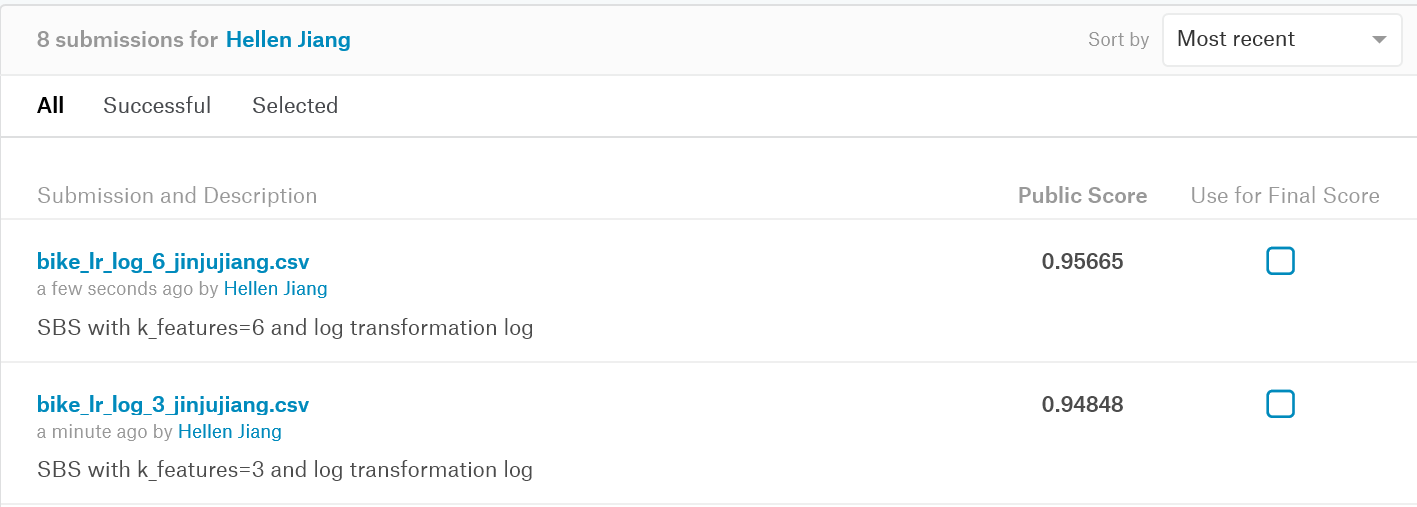

From above kaggle testing results, k_features=3 performed better than k_features=6.

#  Core task: bike demand extension 3 (LR +  Regularization)

## L1 and L2 regularization for Linear Regression
Regularization is a way of penalizing the model for excessive complexity, and this helps reduce the risk of  overfitting.

There are many ways of doing regularization but these two are the major ones:
* **L2-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}w_j^2
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_2^2
$$
* **L1-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}|w_j|
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_1
$$

Using the features and the transformed target feature, log(count+1), from the previous question (question 8), use SKLearn   Ridge and LASSO linear regression classes to perform feature selection. Use gridsearch to determine best value for $\alpha$ the mixing coefficent associated with the penalty term in regularized linear regression.

* Please put all modeling steps in a Pipeline
* NOTE please keep the OHE step separate preprocessing step for this homework
* Present your experimental results in tabular form
* Describe the linear regression model, number of input features used, MAE, RMSE and MAPE, feature familires used (e.g., Baseline features, Season OHE, etc.).
* Please do a Kaggle submission with your best linear regression model
* Screenshot your kaggle submission results
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). Were the selected features here the same as what you selected in your solution to Section 8?

## Data Preprocessing

In [92]:
#load data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
train=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\train.csv')
#Transform datetime into year,month,day,hour
train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): based 
#Define onehot encoder function
def onehotencoderhome(traindata,feature):
    # Create a new column called df.weather1 where the value is 1
    # if df.weather is 1 and 0 if not
    for f in np.unique(traindata[feature]):
        newfeature=feature+str(f)
        traindata[newfeature] = np.where(traindata[feature]==f, 1, 0)

    #drop the original feature    
    return traindata.drop(feature, axis=1)
#Onehot Encoder for weather,season, year
train=onehotencoderhome(train,"weather")
train=onehotencoderhome(train,"season")
train=onehotencoderhome(train,"year")
# Create a new column called df.hour1 where the value is 1
'''
    hour3-High       : 7-9 and 17-19 hours
     hour2-Average    : 10-16 hours
     hour1-Low        : 0-6 and 20-24 hours'''

train['hour1'] = np.where((((train['hour']>=0)&(train['hour']<=6))|((train['hour']>=20)&(train['hour']<=24))), 1, 0)
train['hour3'] = np.where((((train['hour']>=7)&(train['hour']<=9))|((train['hour']>=17)&(train['hour']<=19))), 1, 0)
train['hour2'] = np.where(((train['hour']>=10)&(train['hour']<=16)), 1, 0)

# dont forget to drop the original feature
train=train.drop(['hour'], axis=1)
#X=features,y=target
y =train['count']
X = train.drop(['datetime','registered', 'casual', 'count'], axis=1)
#double check the data
X.iloc[0:2,:]
#split training dataset into training and test parts
from sklearn.cross_validation import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
print("training datasets:",X_train.shape)
print("Validate datasets:",X_test.shape)
#Transform y_train by log function
log_y_train=np.nan_to_num(np.array([np.log(v+1) for v in y_train]))

training datasets: (7620, 21)
Validate datasets: (3266, 21)


## Pipeline+GridsearchCV

### L1 Regulation-Ridge

In [81]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression

In [82]:

rdg_Reg=Ridge()
sbs=SBS(rdg_Reg, k_features=1, scoring=explained_variance_score)
pipe_lr = Pipeline([
        ("std_scaler", StandardScaler()),
        ('sbs', sbs)
    ])
pipe_lr.fit(X_train,log_y_train)
k_feat = [len(k) for k in sbs.subsets_]
list(zip( np.arange(0, len(sbs.scores_)), k_feat, np.round(sbs.scores_, 3), sbs.subsets_)  )

[(0,
  21,
  0.57899999999999996,
  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)),
 (1,
  20,
  0.57899999999999996,
  (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)),
 (2,
  19,
  0.57899999999999996,
  (0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)),
 (3,
  18,
  0.57899999999999996,
  (0, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20)),
 (4,
  17,
  0.57899999999999996,
  (0, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20)),
 (5,
  16,
  0.57899999999999996,
  (0, 2, 3, 4, 6, 7, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20)),
 (6,
  15,
  0.57899999999999996,
  (0, 2, 3, 4, 6, 7, 10, 12, 13, 14, 16, 17, 18, 19, 20)),
 (7,
  14,
  0.57899999999999996,
  (0, 2, 3, 4, 6, 7, 10, 13, 14, 16, 17, 18, 19, 20)),
 (8, 13, 0.57899999999999996, (0, 2, 3, 4, 6, 7, 10, 14, 16, 17, 18, 19, 20)),
 (9, 12, 0.57899999999999996, (0, 2, 3, 4, 6, 7, 10, 14, 16, 18, 19, 20)),
 (10, 11, 0.57899999999999996, (0,

The best subset features are[2, 4, 6, 7, 10, 14, 16, 18, 19]

In [83]:
best_subset = list(sbs.subsets_[12])
best_subset

[2, 4, 6, 7, 10, 14, 16, 18, 19]

In [84]:
#selected best column name by SBS
subsets_column=X_train.columns[:][best_subset]
subsets_column

Index(['temp', 'humidity', 'day', 'month', 'weather3', 'season3', 'year0',
       'hour1', 'hour3'],
      dtype='object')

In [85]:

param_grid={"ridge__alpha":[0.001,0.01,0.1,1.0,10,100]}
rdg_Reg=Ridge()
#sbs=SBS(rdg_Reg, k_features=1, scoring=explained_variance_score)
pipe_lr = Pipeline([
    ('standardize', StandardScaler()),
    ('ridge', Ridge())
])
best_subsets_index = list(sbs.subsets_[12])
subsets_column=X_train.columns[:][best_subsets_index]

grid_search=GridSearchCV(pipe_lr,param_grid,cv=5,refit=True)
grid_search.fit(X_train.loc[:,subsets_column],log_y_train)
#list(zip( np.arange(0, len(sbs.scores_)), k_feat, np.round(sbs.scores_, 3), sbs.subsets_)  )

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [86]:
print(grid_search.best_score_)
print(grid_search.best_estimator_)

0.564172438665
Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])


### Kaggle Prediction-Ridge

In [87]:
def rmsle(y,y_):
    log1=np.nan_to_num(np.array([np.log(v+1) for v in y]))
    log2=np.nan_to_num(np.array([np.log(v+1) for v in y_]))
    calc=(log1-log2)**2
    return np.sqrt(np.mean(calc))
#keep a log book to track experiments
expLog = pd.DataFrame(columns=["Model description","RMSLE train", 'RMSLE test','R2 train','R2 test'])

In [88]:
from sklearn.metrics import accuracy_score
model_name="Linear Regression-Ridge"
model = grid_search.best_estimator_ # BEST model trained on 100% of training data since by default refit=True
y_train_pred_log = model.predict(X_train.loc[:,subsets_column])
y_test_pred_log = model.predict(X_test.loc[:,subsets_column])
y_train_pred=np.nan_to_num(np.array([np.e**(v)-1 for v in y_train_pred_log]))
y_test_pred=np.nan_to_num(np.array([np.e**(v)-1 for v in y_test_pred_log]))
expLog.loc[len(expLog)] = [model_name,  
                np.round(rmsle(y_train, y_train_pred), 3),
                np.round(rmsle(y_test, y_test_pred),3),
                np.round(r2_score(y_train, y_train_pred), 3),
                np.round(r2_score(y_test, y_test_pred), 3)]
expLog

,Model description,RMSLE train,RMSLE test,R2 train,R2 test
0,Linear Regression-Ridge,0.935,0.935,0.543,0.507


In [89]:
#load kaggle test data
test=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\test.csv')

#generate features from datetime
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})
#Obtain features
X_test=test.iloc[:,1:]
#Onehot Encoder for weather,season, year
X_test=onehotencoderhome(X_test,"weather")
X_test=onehotencoderhome(X_test,"season")
X_test=onehotencoderhome(X_test,"year")
# Create a new column called df.hour1 where the value is 1
'''
    hour3-High       : 7-9 and 17-19 hours
     hour2-Average    : 10-16 hours
     hour1-Low        : 0-6 and 20-24 hours'''

X_test['hour1'] = np.where((((X_test['hour']>=0)&(X_test['hour']<=6))|((X_test['hour']>=20)&(X_test['hour']<=24))), 1, 0)
X_test['hour3'] = np.where((((X_test['hour']>=7)&(X_test['hour']<=9))|((X_test['hour']>=17)&(X_test['hour']<=19))), 1, 0)
X_test['hour2'] = np.where(((X_test['hour']>=10)&(X_test['hour']<=16)), 1, 0)

# dont forget to drop the original feature
X_test=X_test.drop(['hour'], axis=1)
X_test.head()


,holiday,workingday,temp,atemp,humidity,windspeed,day,month,weather1,weather2,...,weather4,season1,season2,season3,season4,year0,year1,hour1,hour3,hour2
0,0,1,10.66,11.365,56,26.0027,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0
1,0,1,10.66,13.635,56,0.0000,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0
2,0,1,10.66,13.635,56,0.0000,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0
3,0,1,10.66,12.880,56,11.0014,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0
4,0,1,10.66,12.880,56,11.0014,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0


In [90]:
df_submit = test
df_submit = df_submit.drop(['season', 'holiday', 'workingday','weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month', 'year'], axis=1)

y_test_pred_log=model.predict(X_test.loc[:,subsets_column])
y_test_pred=np.nan_to_num(np.array([np.e**(v)-1 for v in y_test_pred_log]))
df_submit['count'] = np.round(y_test_pred)
df_submit.head()

,datetime,count
0,2011-01-20 00:00:00,16.0
1,2011-01-20 01:00:00,16.0
2,2011-01-20 02:00:00,16.0
3,2011-01-20 03:00:00,16.0
4,2011-01-20 04:00:00,16.0


In [91]:
#create submission file
df_submit[["datetime","count"]].to_csv('bike_lr_ridge_jinjujiang.csv', index=False)

### L1 Regulation-LASSO

In [93]:

sbs=SBS(Lasso(), k_features=1, scoring=explained_variance_score)
pipe_lr = Pipeline([
        ("std_scaler", StandardScaler()),
        ('sbs', sbs)
    ])
pipe_lr.fit(X_train,log_y_train)
k_feat = [len(k) for k in sbs.subsets_]
#list(zip( np.arange(0, len(sbs.scores_)), k_feat, np.round(sbs.scores_, 3), sbs.subsets_)  )

In [94]:
def rmsle(y,y_):
    log1=np.nan_to_num(np.array([np.log(v+1) for v in y]))
    log2=np.nan_to_num(np.array([np.log(v+1) for v in y_]))
    calc=(log1-log2)**2
    return np.sqrt(np.mean(calc))
#keep a log book to track experiments
expLog_1 = pd.DataFrame(columns=["Model description","K","RMSLE train", 'RMSLE test','R2 train','R2 test'])
param_grid={"lasso__alpha":[0.001,0.01,0.1,1.0,10,100]}
#rdg_Reg=Ridge()
#sbs=SBS(rdg_Reg, k_features=1, scoring=explained_variance_score)
pipe_lr = Pipeline([
    ('standardize', StandardScaler()),
    ('lasso', Lasso())
])
for i in range(0,X_train.shape[1]):

    best_subsets_index = list(sbs.subsets_[i])
    subsets_column=X_train.columns[:][best_subsets_index]

    grid_search=GridSearchCV(pipe_lr,param_grid,cv=10,refit=True)
    grid_search.fit(X_train.loc[:,subsets_column],log_y_train)
    model_name="Linear Regression-Lasso"
    model = grid_search.best_estimator_ # BEST model trained on 100% of training data since by default refit=True
    y_train_pred_log = model.predict(X_train.loc[:,subsets_column])
    y_test_pred_log = model.predict(X_test.loc[:,subsets_column])
    y_train_pred=np.nan_to_num(np.array([np.e**(v)-1 for v in y_train_pred_log]))
    y_test_pred=np.nan_to_num(np.array([np.e**(v)-1 for v in y_test_pred_log]))
    expLog_1.loc[len(expLog_1)] = [model_name,i,  
                    np.round(rmsle(y_train, y_train_pred), 3),
                    np.round(rmsle(y_test, y_test_pred),3),
                    np.round(r2_score(y_train, y_train_pred), 3),
                    np.round(r2_score(y_test, y_test_pred), 3)]
expLog_1


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,Model description,K,RMSLE train,RMSLE test,R2 train,R2 test
0,Linear Regression-Lasso,0,0.934,0.935,0.547,0.512
1,Linear Regression-Lasso,1,0.934,0.935,0.547,0.512
2,Linear Regression-Lasso,2,0.948,0.947,0.465,0.440
3,Linear Regression-Lasso,3,1.187,1.187,0.175,0.165
4,Linear Regression-Lasso,4,1.187,1.187,0.175,0.165
5,Linear Regression-Lasso,5,1.199,1.202,0.111,0.102
6,Linear Regression-Lasso,6,1.199,1.202,0.111,0.102
7,Linear Regression-Lasso,7,1.206,1.205,0.115,0.105
8,Linear Regression-Lasso,8,1.214,1.211,0.107,0.096
9,Linear Regression-Lasso,9,1.215,1.211,0.112,0.102


In [95]:
param_grid={"lasso__alpha":[0.001,0.01,0.1,1.0,10,100]}
#rdg_Reg=Ridge()
#sbs=SBS(rdg_Reg, k_features=1, scoring=explained_variance_score)
pipe_lr = Pipeline([
    ('standardize', StandardScaler()),
    ('lasso', Lasso())
])

best_subsets_index = list(sbs.subsets_[1])
subsets_column=X_train.columns[:][best_subsets_index]

grid_search=GridSearchCV(pipe_lr,param_grid,cv=10,refit=True)
grid_search.fit(X_train.loc[:,subsets_column],log_y_train)
model_name="Linear Regression-Lasso"
model = grid_search.best_estimator_ # BEST model trained on 100% of training data since by default refit=True
y_train_pred_log = model.predict(X_train.loc[:,subsets_column])
y_test_pred_log = model.predict(X_test.loc[:,subsets_column])
y_train_pred=np.nan_to_num(np.array([np.e**(v)-1 for v in y_train_pred_log]))
y_test_pred=np.nan_to_num(np.array([np.e**(v)-1 for v in y_test_pred_log]))
expLog.loc[len(expLog)] = [model_name,  
                np.round(rmsle(y_train, y_train_pred), 3),
                np.round(rmsle(y_test, y_test_pred),3),
                np.round(r2_score(y_train, y_train_pred), 3),
                np.round(r2_score(y_test, y_test_pred), 3)]
expLog

,Model description,RMSLE train,RMSLE test,R2 train,R2 test
0,Linear Regression-Ridge,0.935,0.935,0.543,0.507
1,Linear Regression-Lasso,0.934,0.935,0.547,0.512


### Kaggle Prediction-Lasso

In [96]:
#load kaggle test data
test=pd.read_csv('C:\\Users\\hjiang\\i526\\Lab\\data\\bike\\test.csv')

#generate features from datetime
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})
#Obtain features
X_test=test.iloc[:,1:]
#Onehot Encoder for weather,season, year
X_test=onehotencoderhome(X_test,"weather")
X_test=onehotencoderhome(X_test,"season")
X_test=onehotencoderhome(X_test,"year")
# Create a new column called df.hour1 where the value is 1
'''
    hour3-High       : 7-9 and 17-19 hours
     hour2-Average    : 10-16 hours
     hour1-Low        : 0-6 and 20-24 hours'''

X_test['hour1'] = np.where((((X_test['hour']>=0)&(X_test['hour']<=6))|((X_test['hour']>=20)&(X_test['hour']<=24))), 1, 0)
X_test['hour3'] = np.where((((X_test['hour']>=7)&(X_test['hour']<=9))|((X_test['hour']>=17)&(X_test['hour']<=19))), 1, 0)
X_test['hour2'] = np.where(((X_test['hour']>=10)&(X_test['hour']<=16)), 1, 0)

# dont forget to drop the original feature
X_test=X_test.drop(['hour'], axis=1)
X_test.head()


,holiday,workingday,temp,atemp,humidity,windspeed,day,month,weather1,weather2,...,weather4,season1,season2,season3,season4,year0,year1,hour1,hour3,hour2
0,0,1,10.66,11.365,56,26.0027,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0
1,0,1,10.66,13.635,56,0.0000,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0
2,0,1,10.66,13.635,56,0.0000,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0
3,0,1,10.66,12.880,56,11.0014,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0
4,0,1,10.66,12.880,56,11.0014,3,1,1,0,...,0,1,0,0,0,1,0,1,0,0


In [97]:
df_submit = test
df_submit = df_submit.drop(['season', 'holiday', 'workingday','weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month', 'year'], axis=1)

y_test_pred_log=model.predict(X_test.loc[:,subsets_column])
y_test_pred=np.nan_to_num(np.array([np.e**(v)-1 for v in y_test_pred_log]))
df_submit['count'] = np.round(y_test_pred)
df_submit.head()

,datetime,count
0,2011-01-20 00:00:00,16.0
1,2011-01-20 01:00:00,17.0
2,2011-01-20 02:00:00,17.0
3,2011-01-20 03:00:00,16.0
4,2011-01-20 04:00:00,16.0


In [98]:
#create submission file
df_submit[["datetime","count"]].to_csv('bike_lr_lasso_jinjujiang.csv', index=False)

## Kaggle Submission

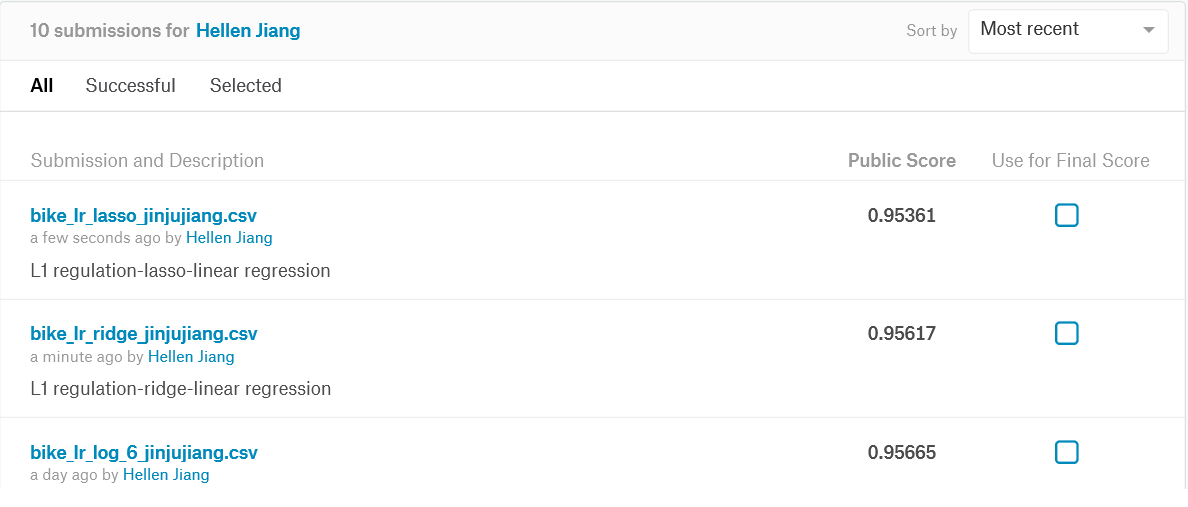

# Optional Task: Linear Regression via GD from scratch

The objective function of linear regression is the following:
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2,\\
n = \left|X_{\text{train}}\right|
$$
So we want to minimize the **squared value** of difference between predictions and real answers. It is called Mean Squared Error (MSE). Gradient Descent is the way of optimizing this complex functional and tune weigths $\mathbf{w}$ and bias $b$.

To be able to treat weigths $\mathbf{w}$ and bias $b$ homogeneously we're going to augment the data with the "shell" feature (all $1$'s). Then we can add one more parameter to the weight vector and treat it as a *bias*.
$$
\mathbf{x}' :=
\begin{bmatrix}
\mathbf{x}\\
1
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
\mathbf{w}\\
b
\end{bmatrix}
\\
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
$$
In this way it is much more easier to carry out oprimization process.

To simplify it further and do it in "*tensor*" way let's rewrite it in matrix form. Let's introduce data matrix (the same as dataframe we used everywhere above)

$$
\text{X}' =
\begin{bmatrix}
\mathbf{x'}_1^{\text{T}}\\
\vdots\\
\mathbf{x'}_n^{\text{T}}
\end{bmatrix},\quad
\mathbf{y} = 
\begin{bmatrix}
y_1\\
\vdots\\
y_n
\end{bmatrix}
$$

Matrix $\text{X}$ contains objects in its rows and features in its columns. Vector $\mathbf{y}$ is a vector of answers. Then the objective can be rewritten as follows:

$$
f(\boldsymbol{\theta}) = \frac{1}{n}\|\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\|_2^2
$$

Then the gradient can be easily calculated in vectorized form:

$$
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\text{X}'^{\text{T}}\left(\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\right)
$$

Exactly this computations are implemented down below in **BasicLinearRegressionHomegrown** class

## Data

Split into train and test set (with the same $\text{random_state}$ which means we can compare results)

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaling

In [163]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Basic version of homegrown Linear Regression

In [164]:
class BasicLinearRegressionHomegrown(object):
    
    def __init__(self):
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [], 
                        "coef": [], 
                        "intercept": [], 
                        "grad": []}
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        return gradient
    
    # full gradient descent, i.e., not stochastic gd
    def _gd(self, X, y, max_iter, alpha=0.0005):
        """
        Runs GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=1000):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
        Return:
            self
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])
        
        # do full gradient descent
        self._gd(X, y, max_iter)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self
        
    def score(self, X, y):
        """
        Calculate RMSE metric

        Args:
            X(ndarray):      objects
            y(ndarray):      answers
        Return:
            rmse(float):     RMSE
        """
        pred = self.predict(X)
        error = pred - y
        rmse = (np.sum(error ** 2) / X.shape[0]) ** 0.5
        return rmse
        
    def predict(self, X):
        """
        Make a prediction

        Args:
            X(ndarray):      objects
        Return:
            pred(ndarray):   predictions
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            pred = np.dot(X, self._theta)
        else:
            pred = np.dot(X, self.coef_) + self.intercept_
        return pred

Create model

In [165]:
model_homegrown = BasicLinearRegressionHomegrown()
model_sk=LinearRegression()

## Fitting

In [166]:
model_homegrown.fit(X_train, y_train, max_iter=40000)
model_sk.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

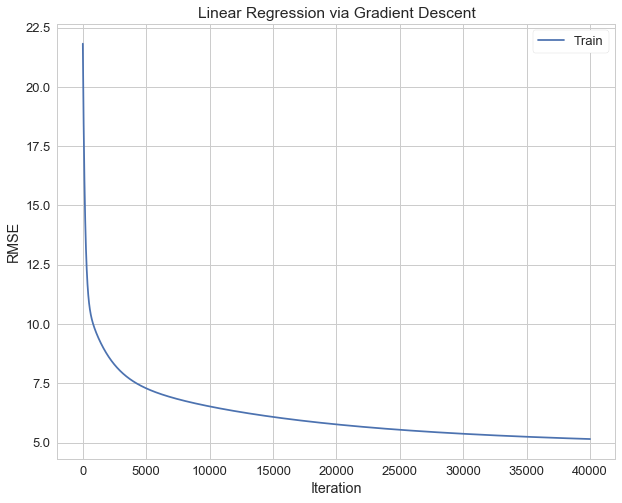

In [167]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown.history["cost"], label="Train")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Gradient Descent")
plt.legend();

## Evaluation

In [168]:
models = [model_sk, model_homegrown]
models_names = ["Sklearn", "Homegrown"]

In [169]:

evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Train,3.570690,5.148422,17.504468
Homegrown Test,3.384323,5.290366,18.214940


# Optional Assignment: Random Search

* Implement random search algorithm for Linear Regression as a child of **BasicLinearRegressionHomegrown** class. Then you need to reimplement only solution method (change GD to Random Search)
* Compare its performance with the previous implementations

Random search algorithm consists of the following steps:
1. Sample a set of weigths from some distribution. Here we're going to use Uniform distribution.
$$
\boldsymbol{\Theta} = \{\boldsymbol{\theta}_1, \boldsymbol{\theta}_2 \ldots \boldsymbol{\theta}_{N}\}
$$
2. Now we have a set of weights $\boldsymbol{\Theta}$ for Linear Regression. The idea is to choose the best one according to the objective.
$$
\boldsymbol{\theta^*} = \underset{\boldsymbol{\Theta}}{\text{argmin}} \sum_{i=1}^{n}\left[\boldsymbol{\theta} \cdot \mathbf{x_i} - y_i\right]^2
$$

In [170]:
class RandomSearchLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(RandomSearchLinearRegressionHomegrown, self).__init__()
        self.history = {"cost": [], 
                        "coef": [], 
                        "intercept": []}
        
    def _rs(self, X, y, max_iter):
        """
        Runs Random Search and logs error and weigths at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of points to sample
        Return:
            None
        """
        
        # use the following numpy command to generate
        # random sample from the weight space
        sampled_weights = np.random.random(size=(max_iter, len(self._theta))) * 20 - 10
        
        # go ahead and choose the best of sampled weights
        # according to the objective
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
        rmse=float('inf')
        
        for weights_ in sampled_weights:
            self.coef_=weights_[1:].copy()
            self.intercept_=weights_[0].copy()
            self._theta=weights_.copy()
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            new_rmse = self.score(X, y)
            self.history["cost"].append(rmse)
            if new_rmse<rmse:
                rmse=new_rmse
                best_weights=weights_.copy()
            # calculate gradient
            #grad = self._grad(X, y)
            #self.history["grad"].append(grad)
            
            # do gradient step
            #self._theta -= alpha * grad
        self.coef_=best_weights[1:].copy()
        self.intercept_=best_weights[0].copy()
        self._theta=best_weights.copy()
    
    def fit(self, X, y, max_iter=1000):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of points to sample
        Return:
            self
        """
        X = np.c_[np.ones(X.shape[0]), X]
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])
        
        self._rs(X, y, max_iter)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self

Create model

In [171]:
model_homegrown_rs = RandomSearchLinearRegressionHomegrown()

Fitting

In [172]:
model_homegrown_rs.fit(X_train, y_train, max_iter=10000)

Evaluation

In [173]:
models = [model_sk, model_homegrown, model_homegrown_rs]
models_names = ["Sklearn", "Homegrown Full GD", "Homegrown RS"]

In [174]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Full GD Train,3.570690,5.148422,17.504468
Homegrown Full GD Test,3.384323,5.290366,18.214940
Homegrown RS Train,5.994334,7.587925,33.199796
Homegrown RS Test,5.832513,7.320634,34.890905


# Optional Assignment: Numerical Calculation
* **BasicLinearRegressionHomegrown** class provides you with the method *_grad* that allows to compute analytical gradient. This function is correct
* Inheret from this class and implement a method for numerical approximation of gradient (see placeholder below)
* Check your function by comparing with the analytical one. They **should** be similar.
* Plot the difference of analytical and numerical gradients and describe what you observe

The formula for analytical gradient (from calculus):

$$
\nabla f(\mathbf{x}) = 
\begin{bmatrix}
\frac{\partial f}{\partial x_1}\\
\vdots\\
\frac{\partial f}{\partial x_m}
\end{bmatrix}, \text{ where } m \text{ is the space dimension}\\
\frac{\partial f}{\partial x_1} = \lim_{\alpha \rightarrow 0} \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha}
$$

For sufficiently small $\alpha$ one can approximate partial derivative by simple throwing out the limit operator

$$
\frac{\partial f}{\partial x_1} \approx \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha} = \left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
$$

Then the final approximation of the gradient is:

$$
\nabla f(\mathbf{x}) \approx \nabla_{\text{num}\,\,} f(\mathbf{x}) = \begin{bmatrix}
\left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
\vdots\\
\left( \frac{\partial f}{\partial x_m} \right)_{\text{num}}
\end{bmatrix}
$$

The common way of measuring the difference between vectors is the following:
$$
\text{er} = \frac{\|\nabla f(\mathbf{x}) - \nabla_{\text{num}\,\,}f(\mathbf{x})\|_2^2}{\|\nabla f(\mathbf{x})\|_2^2} = \frac{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x}) - \nabla^j_{\text{num}\,\,}f(\mathbf{x})\right)^2}{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x})\right)^2}
$$

In [178]:
x=np.array([1,2,3])
y=np.array([4,5,6])
x.dot(y)

32

In [180]:
class TweakedLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(TweakedLinearRegressionHomegrown, self).__init__()
        self.history["grad_num"] = []
        
    @staticmethod
    def _gradient_approximation(f, x,h):
        """
        Returns the numerical gradient of the function f at the point x

        Args:
            f(callable): function that takes the point x as an input 
                         and returns the value of the function
            x(ndarray): numpy array which contains the coordinates 
                        of the point to evaluate gradient
        Return:
            grad_num(ndarray): the numerical approximation 
                               of the gradient
        """

        grad_num = np.zeros(len(x))

        #==================================================#
        #               Place your code here               #
        #==================================================#
        for i in range(len(x)):
            grad_num[i]=(f(x[i]+h)-f(x[i]))/h
        return grad_num          

        
    
    def _grad_num(self, X, y):
        """
        Returns the numerical gradient of the LinearRegression 
        objective function

        Args:
            X(ndarray): train objects
            y(ndarray): answers for train objects
        Return:
            grad_num(ndarray): the numerical approximation 
                               of the gradient
        """
        
        grad_num = np.zeros(X.shape[1])
        h=0.0001
        #==================================================#
        #               Place your code here               #
        #         Use _gradient_approximation method       #
        #==================================================#
        pred = np.dot(X, self._theta)
        error = pred - y
        rmse = (np.sum(error ** 2) / X.shape[0]) ** 0.5
        for i in range(X.shape[1]):
            new_theta=self._theta.copy()
            new_theta[i]+=h
            pred1=np.dot(X, new_theta)
            error1 = pred - y
            rmse1 = (np.sum(error ** 2) / X.shape[0]) ** 0.5
            grad_num[i]=(rmse1-rmse)/h
            
        
        
        return grad_num
    
    def _gd(self, X, y, max_iter, alpha=0.001):
        """
        Runs GD and logs error, weigths, gradient and 
        numerical gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            grad_num = self._grad_num(X, y)
            self.history["grad_num"].append(grad_num)
            
            self._theta -= alpha * grad

Create model

In [181]:
model_homegrown_check_grad = TweakedLinearRegressionHomegrown()

Fitting

In [182]:
model_homegrown_check_grad.fit(X_train, y_train, max_iter=40000)

Plotting error curves

In [183]:
def relative_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1. / np.sum(grad ** 2, axis=1)

In [184]:
def absolute_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1.

In [185]:
grad_num = np.array(model_homegrown_check_grad.history["grad_num"])
grad = np.array(model_homegrown_check_grad.history["grad"])

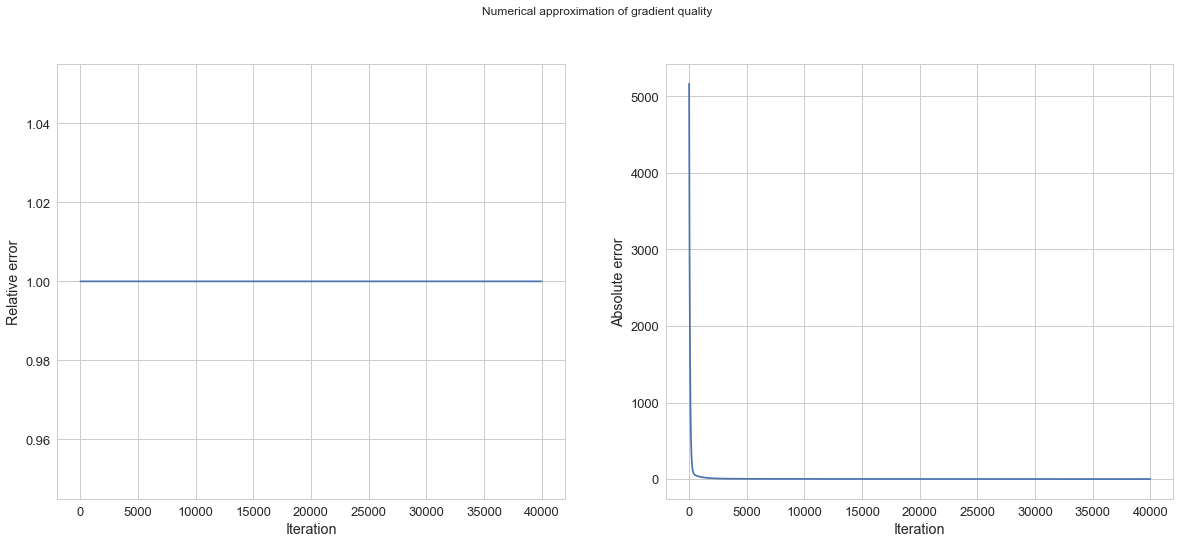

In [186]:
plt.figure(figsize=(20, 8))
plt.suptitle("Numerical approximation of gradient quality")
plt.subplot(121)
plt.plot(relative_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.subplot(122)
plt.plot(absolute_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Absolute error")
plt.show()

# Optional Assignment: Stochastic Gradient Descent
* Implement stochastic gradient descent algorithm as a member of a class
* Check that analytical gradient is right via numerical gradient function from **TweakedLinearRegressionHomegrown**

In Full GD we do a descent step only after the calculation of the gradient over the whole set of data. In this case the gradient is precise and gives the best possible direction. But it can require quite a lot of time if we have huge amounts of data. 

In practice we can get faster convergence if we calculate the gradient not over the whole set of data but over the small (size of $B$) **batch** of it.

$$
\nabla f(\boldsymbol{\theta}) \approx \nabla_{\text{batch}\,\,} f(\boldsymbol{\theta}) = \frac{2}{n}\sum_{i=1}^{B}\left(\mathbf{x}'_{a_i}\cdot \boldsymbol{\theta} - y_{a_i}\right)\cdot \mathbf{x}'_{a_i}
$$
where $a_i$ is an array of indices of objects which are in this batch. Common approach here that you should use is to shuffle samples randomly and then iterate over them with batches.

So with this batch approach we get an approximation of the real gradient in point $\boldsymbol{\theta}$. This approximation is very cheap and fast to compute (usually $B$ is not too big $-$ from 32 to 256). After obtaining this gradient we do a descent step in this approximate direction and proceed to the next stage of batch descent.

In [187]:
class StochasticLinearRegressionHomegrown(TweakedLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(StochasticLinearRegressionHomegrown, self).__init__()
        self.history["grad_num"] = []
    
    def _sgd(self, X, y, max_iter, batch_size, alpha=0.0005):
        """
        Runs Stochastic GD and logs error, weigths, gradient and 
        numerical gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
        
        for epoch in range(max_iter):
            idxs = np.random.permutation(X.shape[0])
            X = X[idxs]
            y = y[idxs]
            for i in range(0, len(X), batch_size):
                
                self.history["coef"].append(self._theta[1:].copy())
                self.history["intercept"].append(self._theta[0].copy())
                
                rmse = self.score(X, y)
                self.history["cost"].append(rmse)
                
                # calculate gradient
                grad = self._grad(X[i:i + batch_size], y[i:i + batch_size])
                self.history["grad"].append(grad)
                
                # numerical gradient
                grad_num = self._grad_num(X[i:i + batch_size], y[i:i + batch_size])
                self.history["grad_num"].append(grad_num)
            
                # do gradient step
                self._theta -= alpha * grad
        
        
    def fit(self, X, y, max_iter=1000, batch_size=16):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
        Return:
            self
        """
        X = np.c_[np.ones(X.shape[0]), X]
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])

        self._sgd(X, y, max_iter, batch_size)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self

Create model

In [188]:
model_homegrown_sgd = StochasticLinearRegressionHomegrown()

Fitting

In [189]:
model_homegrown_sgd.fit(X_train, y_train, max_iter=1500)

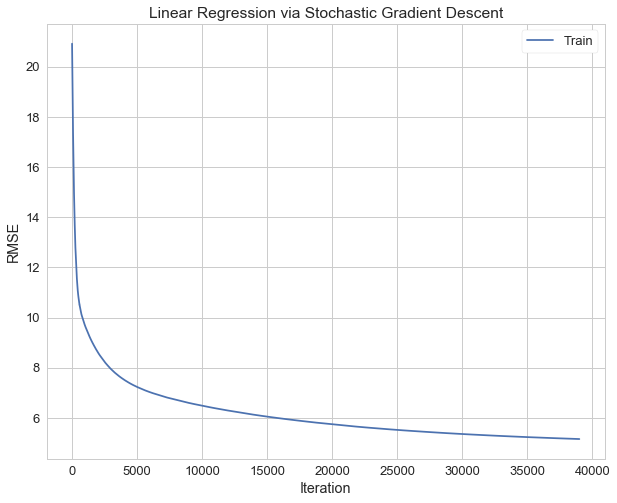

In [190]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown_sgd.history["cost"], label="Train")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Stochastic Gradient Descent")
plt.legend(frameon=True)
plt.show()

Evaluation

In [195]:
models = [model_sk, model_homegrown, model_homegrown_sgd]
models_names = ["Sklearn", "Homegrown Full GD", "Homegrown SGD"]

In [196]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Full GD Train,3.570690,5.148422,17.504468
Homegrown Full GD Test,3.384323,5.290366,18.214940
Homegrown SGD Train,3.569371,5.157622,17.496304
Homegrown SGD Test,3.383569,5.306349,18.208680


## L1 and L2 regularization from scratch
Incorporate L1 and L2 regularization for the BasicLinearRegressionHomegrown class developed above.  Start with L2 regularization.

### L2 Regularization

In [197]:
class BasicLinearRegressionHomegrown(object):
    
    def __init__(self,gamma):
        self.gamma=gamma
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [], 
                        "coef": [], 
                        "intercept": [], 
                        "grad": []}
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]+2*self.gamm*np.sum(self._theta)
        return gradient
    
    # full gradient descent, i.e., not stochastic gd
    def _gd(self, X, y, max_iter, alpha=0.0005):
        """
        Runs GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=1000):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
        Return:
            self
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])
        
        # do full gradient descent
        self._gd(X, y, max_iter)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self
        
    def score(self, X, y):
        """
        Calculate RMSE metric

        Args:
            X(ndarray):      objects
            y(ndarray):      answers
        Return:
            rmse(float):     RMSE
        """
        pred = self.predict(X)
        error = pred - y
        rmse = (np.sum(error ** 2) / X.shape[0]) ** 0.5+self.gamma*np.sum(self._theta**2)
        return rmse
        
    def predict(self, X):
        """
        Make a prediction

        Args:
            X(ndarray):      objects
        Return:
            pred(ndarray):   predictions
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            pred = np.dot(X, self._theta)
        else:
            pred = np.dot(X, self.coef_) + self.intercept_
        return pred

### L1 Regularization

In [ ]:
class BasicLinearRegressionHomegrown(object):
    
    def __init__(self,gamma):
        self.gamma=gamma
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [], 
                        "coef": [], 
                        "intercept": [], 
                        "grad": []}
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]+self.gamma
        return gradient
    
    # full gradient descent, i.e., not stochastic gd
    def _gd(self, X, y, max_iter, alpha=0.0005):
        """
        Runs GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=1000):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
        Return:
            self
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])
        
        # do full gradient descent
        self._gd(X, y, max_iter)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self
        
    def score(self, X, y):
        """
        Calculate RMSE metric

        Args:
            X(ndarray):      objects
            y(ndarray):      answers
        Return:
            rmse(float):     RMSE
        """
        pred = self.predict(X)
        error = pred - y
        rmse = (np.sum(error ** 2) / X.shape[0]) ** 0.5+self.gamma*np.sum(abs(self._theta))
        return rmse
        
    def predict(self, X):
        """
        Make a prediction

        Args:
            X(ndarray):      objects
        Return:
            pred(ndarray):   predictions
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            pred = np.dot(X, self._theta)
        else:
            pred = np.dot(X, self.coef_) + self.intercept_
        return pred

# Optional Assignment: Adaptive step size [no bonus points for this question]

## Line Search of the step size
Instead of doing a gradient step with the fixed step size ($\alpha=0.0005$) consider it as a variable after choosing the step directon (gradient one) and try to optimize it. In other words solve analyticaly the following 1D optimization problem:

$$
f\left(\boldsymbol{\theta}_{t} - \alpha \cdot \nabla f(\boldsymbol{\theta}_{t})\right) \rightarrow \min_{\alpha}
$$



## Modify your GD model to use adaptive step size
* What happens?
* How does it influence the time in terms of number of iterations?

In [52]:
class OptimalStepBasicLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
       
    def __init__(self):
        super(OptimalStepBasicLinearRegressionHomegrown, self).__init__()
        self.history["alpha"] = []
        
    def _gd(self, X, y, max_iter):
        """
        Runs GD and logs error, weigths, gradient at every step.
        Here the optimal step size used with formulas from above.

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
        Return:
            None
        """
        
        for i in range(max_iter):
            
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            # optimum step size
        
            #==================================================#
            #               Place your code here               #
            #==================================================#
            
            
            # do gradient step
            self._theta -= alpha * grad